In [27]:
from qutip import *
about()


QuTiP: Quantum Toolbox in Python
Copyright (c) QuTiP team 2011 and later.
Original developers: R. J. Johansson & P. D. Nation.
Current admin team: Alexander Pitchford, Paul D. Nation, Nathan Shammah, Shahnawaz Ahmed, Neill Lambert, and Eric Giguère.
Project Manager: Franco Nori.
Currently developed through wide collaboration. See https://github.com/qutip for details.

QuTiP Version:      4.4.1
Numpy Version:      1.16.4
Scipy Version:      1.3.1
Cython Version:     0.29.13
Matplotlib Version: 3.1.0
Python Version:     3.7.4
Number of CPUs:     4
BLAS Info:          INTEL MKL
OPENMP Installed:   False
INTEL MKL Ext:      True
Platform Info:      Windows (AMD64)
Installation path:  C:\Users\MatthewThornton\Anaconda3\envs\mtqoi\lib\site-packages\qutip
Please cite QuTiP in your publication.
For your convenience a bibtex reference can be easily generated using `qutip.cite()`


In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib import cm
import numpy as np
import qutip as qt
plt.style.use(['science', 'ieee'])
plt.style.use('science')
qt.settings.auto_tidyup = True

In [2]:
import time, sys
from IPython.display import clear_output

def update_progress(progress):
    bar_length = 20
    if isinstance(progress, int):
        progress = float(progress)
    if not isinstance(progress, float):
        progress = 0
    if progress < 0:
        progress = 0
    if progress >= 1:
        progress = 1

    block = int(round(bar_length * progress))

    clear_output(wait = True)
    text = "Progress: [{0}] {1:.1f}%".format( "#" * block + "-" * (bar_length - block), progress * 100)
    print(text)

In [3]:
def purity(rho):
    if isinstance(rho, list):
        mylist = []
        for idx, val in enumerate(rho):
            mylist.append(((val * val).tr()))
        return mylist
    else:
        return (rho * rho).tr()
#     return (rho * rho).tr()

In [4]:
def plot_wigner(rho, fig=None, ax=None):
    """
    Plot the Wigner function and the Fock state distribution given a density matrix for a Harmonic oscillator mode
    """
    
    if fig is None or ax is None:
        fig, ax = plt.subplots(1,1,figsize=(8,8))
        
    if qt.isket(rho):
        rho = qt.ket2dm(rho)
        
    xvec = np.linspace(-7.5, 7.5, 200)
    
    W = qt.wigner(rho, xvec, xvec)
    wlim = np.abs(W).max()
    
    ax.contourf(xvec, xvec, W, 100, norm=mpl.colors.Normalize(-wlim,wlim), cmap=mpl.cm.get_cmap("RdYlBu"))
    ax.set_xlabel(r"$x_1$", fontsize=16)
    ax.set_ylabel(r"$x_2$", fontsize=16)
    
    return ax

# $ \hat{A} = \hat{a}$

Let us generate some evolution

In [11]:
# defining input parameters
N = 35 # hilbert space size
tlist = np.linspace(0, 1.0, 101) # times over which to solve
gamma = 8.0 # decay rate 
omega = 1.0 # free Hamiltonian frequency 
alphain = 3.0 # input coherent state amplitude

# defining operators
a = qt.destroy(N) # annihilation operator
n = qt.num(N) # number operator 
ad = a.dag() # creation operator 
x = (a + ad)/np.sqrt(2) # position operator. Equivalent to qt.position(N)
p = -1j * (a - ad)/np.sqrt(2) # momentum operator. Equivalent to qt.position(N)

# defining Hamiltonian
H = omega * ad * a


# input state
psi0 = qt.coherent(N, alphain, method="analytic")
coplist = [np.sqrt(gamma) * a]
# result = qt.mesolve(H, psi0, tlist, coplist, [])

# result.states gives a list of density matrices, corresponding to 
# the state at each timestep.

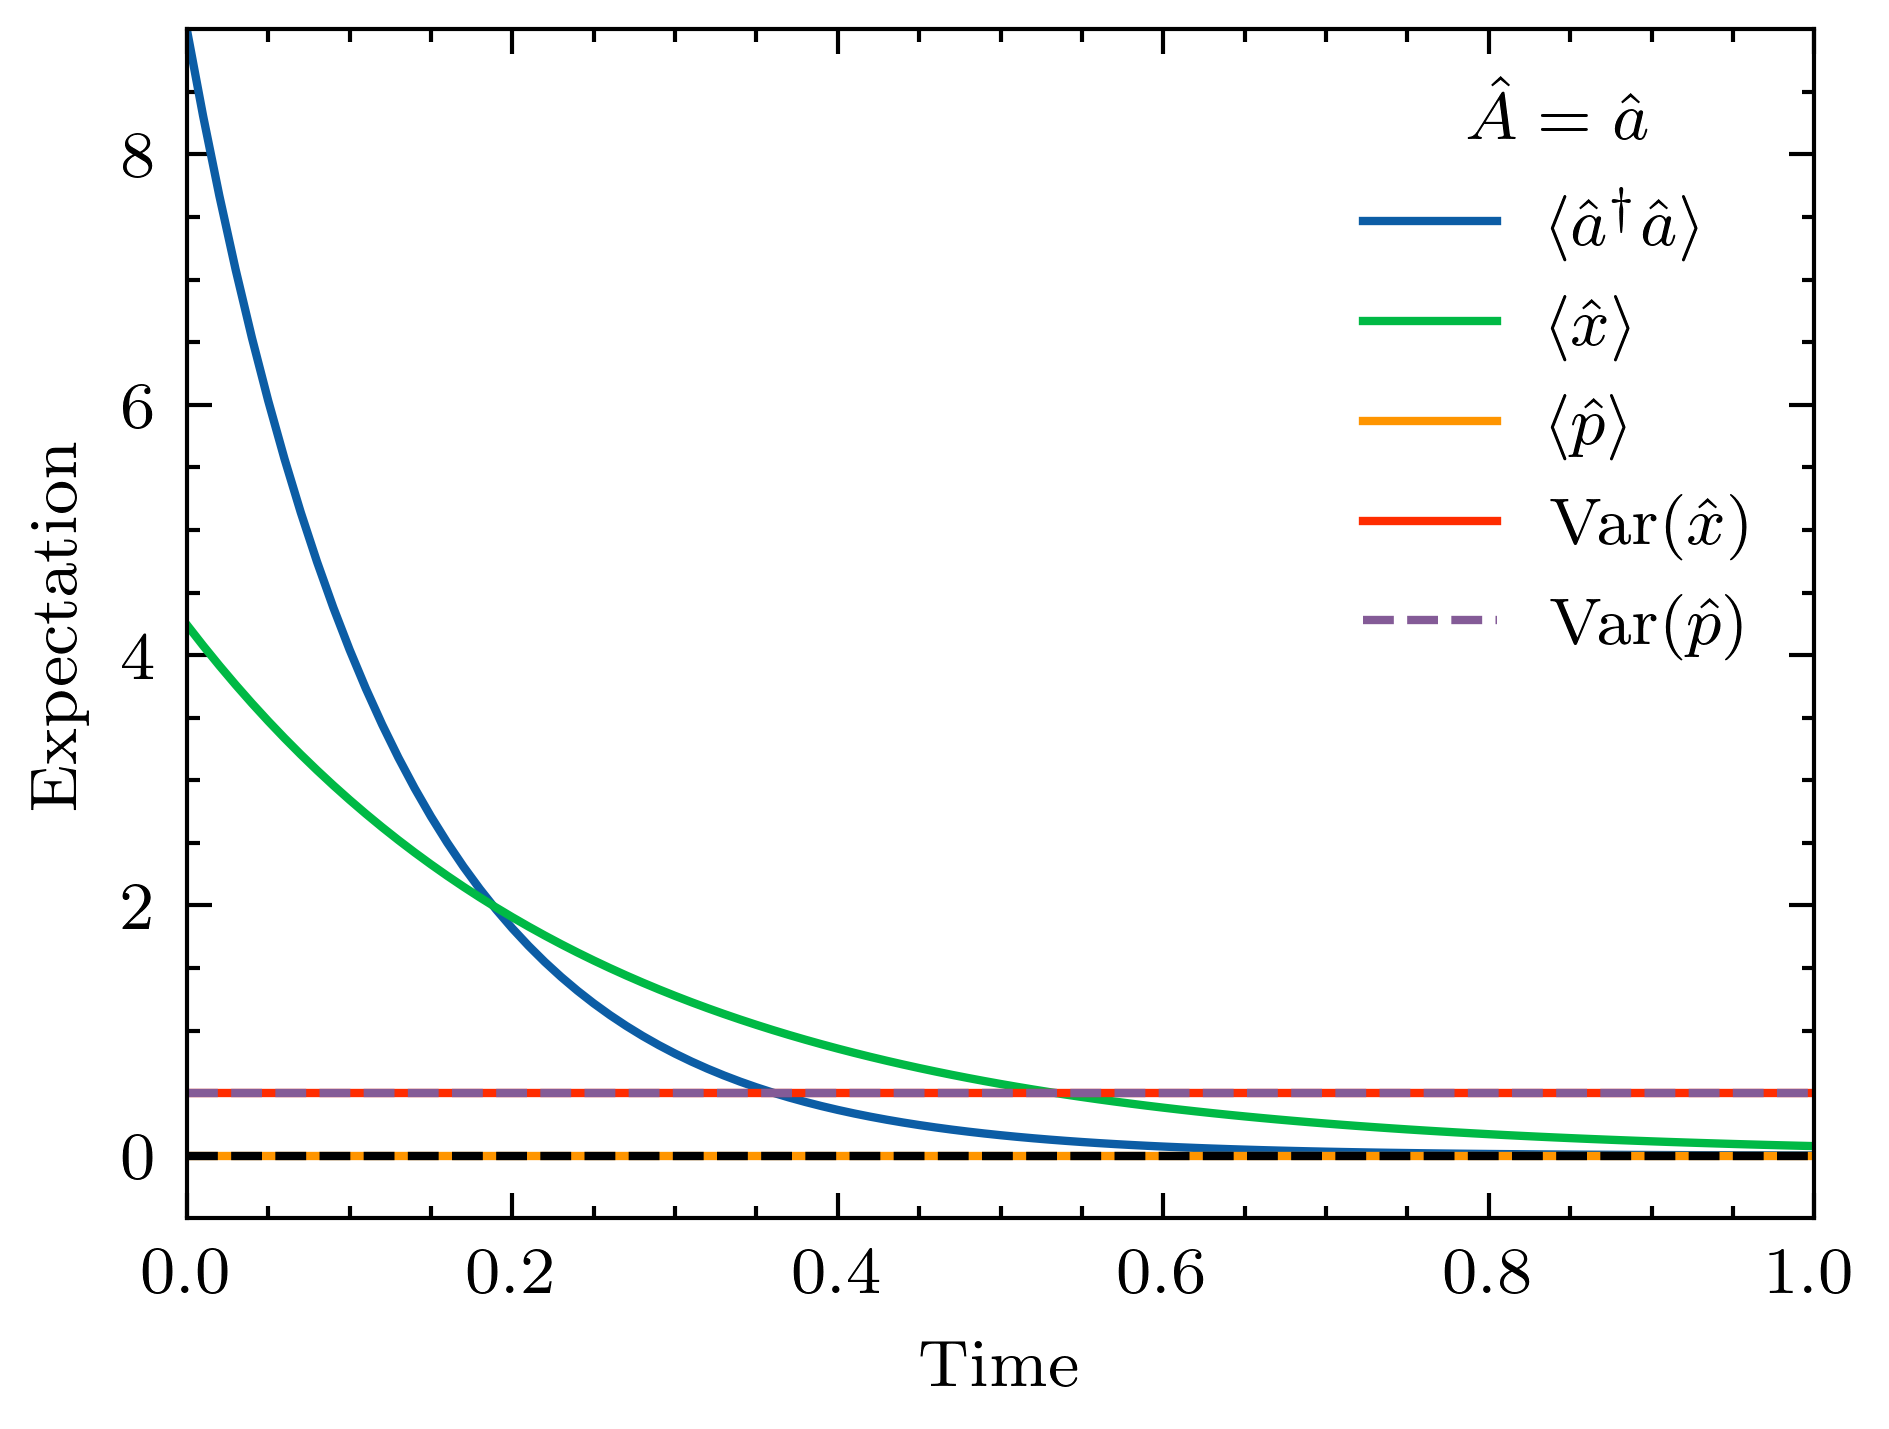

In [51]:
# graph of expectations

const_list_0 = np.full(len(tlist), 0)


ymax = max(qt.expect(n, result.states))
fig, ax = plt.subplots()

ax.plot(tlist, qt.expect(n, result.states), label="$\\langle\\hat{a}^\\dagger \\hat{a} \\rangle$")
# ax.plot(tlist, qt.expect(a, result.states), label="$\\langle\\hat{a}\\rangle$")
ax.plot(tlist, qt.expect(x, result.states), label="$\\langle\\hat{x}\\rangle$")
ax.plot(tlist, qt.expect(p, result.states), label="$\\langle\\hat{p}\\rangle$")
ax.plot(tlist, qt.variance(x, result.states), label="Var($\\hat{x}$)")
ax.plot(tlist, qt.variance(p, result.states), label="Var($\\hat{p}$)", linestyle="--")
ax.plot(tlist, const_list_0, color="black", linestyle="--")

ax.set(xlabel="Time")
ax.set(ylabel="Expectation")
ax.legend(title = "$\\hat{A} = \\hat{a}$", loc=0)
# ax.legend(loc=0)
ax.autoscale(tight=True)
ax.set_ylim([-0.5,ymax]);

fig.savefig("expects_a.pdf")
fig.savefig("expects_a.png", dpi=300)

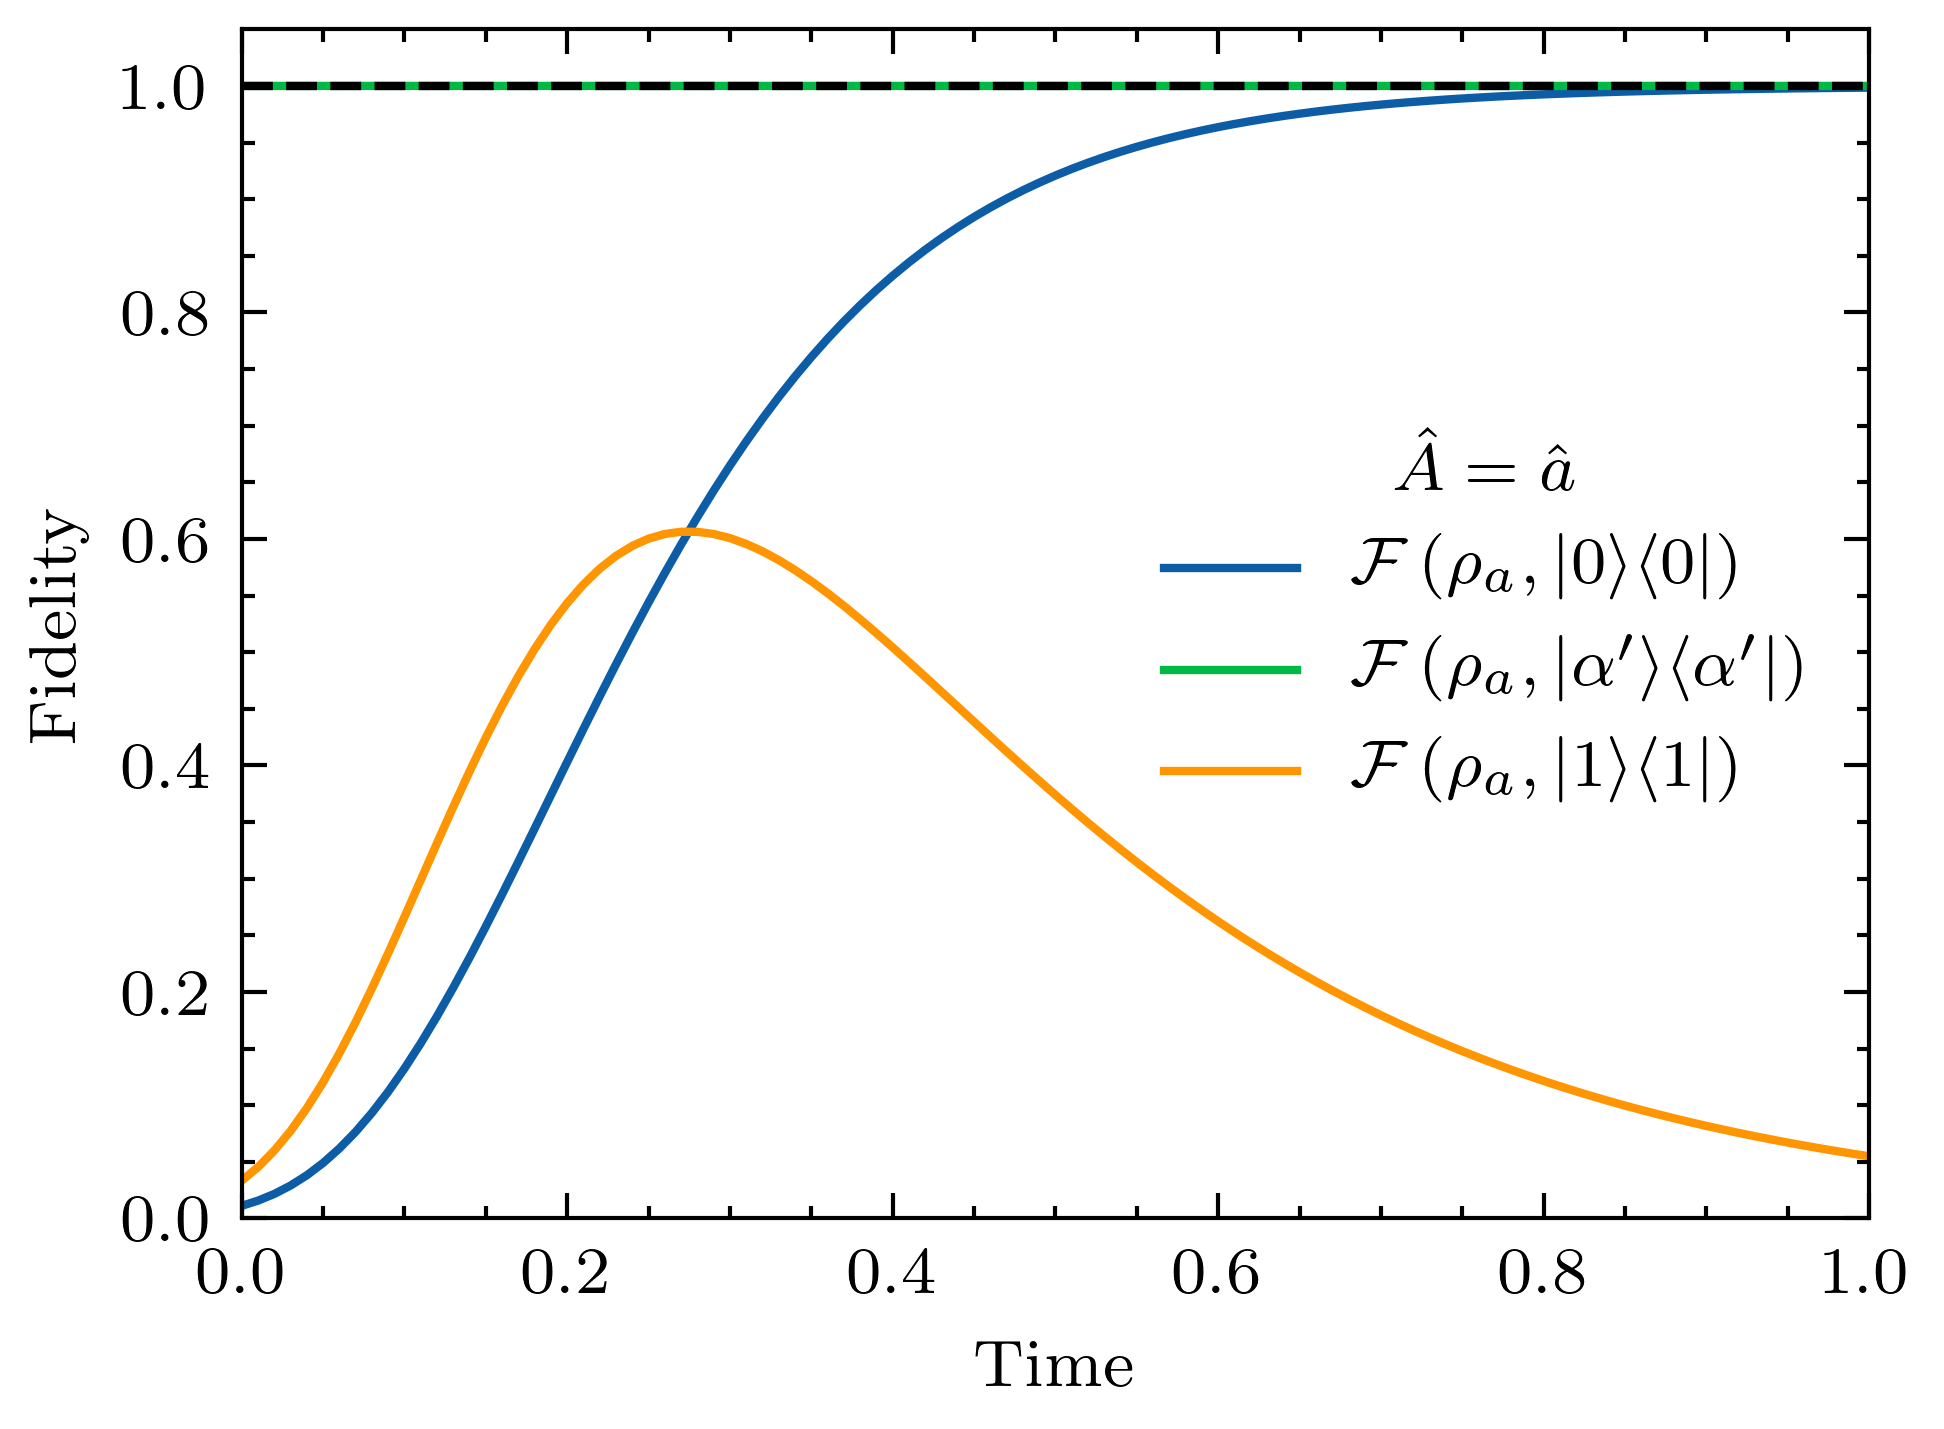

In [52]:
# graph of fidelities to target states

steady_state = qt.coherent(N, 0, method="analytic")
const_list_1 = np.full(len(tlist), 1)

# fidelity to steady state
fid_list_steady = []
for idx, val in enumerate(result.states):
    fid_list_steady.append(qt.fidelity(val, steady_state))
    
    
# fidelity to equivalent coherent state
fid_list_coh = []
for idx, val in enumerate(result.states):
    fid_list_coh.append(qt.fidelity(val, qt.coherent(N, np.sqrt(qt.expect(n, val)))))
    

fid_list_one = []
for idx, val in enumerate(result.states):
    fid_list_one.append(qt.fidelity(val, qt.fock(N, 1)))
fig, ax = plt.subplots()


fid_list_fock = []
for idx, val in enumerate(result.states):
    fid_list_fock.append(qt.fidelity(val, qt.fock(N, int(np.rint(qt.expect(n, val))))))

ax.plot(tlist, fid_list_steady, label="$\\mathcal{F}\\left(\\rho_a, |0\\rangle\\langle 0 |\\right)$")
ax.plot(tlist, fid_list_coh, label="$\\mathcal{F}\\left(\\rho_a, |\\alpha^\\prime\\rangle\\langle \\alpha^\\prime |\\right)$")
ax.plot(tlist, fid_list_one, label="$\\mathcal{F}\\left(\\rho_a, |1\\rangle\\langle 1|\\right)$")
# ax.plot(tlist, fid_list_fock, color="red")                         
ax.plot(tlist, const_list_1, linestyle="--", color="black")
ax.autoscale(tight=True)
ax.set(xlabel="Time")
ax.set(ylabel="Fidelity")
ax.set_ylim([0, 1.05]);
# ax.legend(loc=0)
ax.legend(title = "$\\hat{A} = \\hat{a}$", loc=0)

fig.savefig("fidelities_a.pdf")
fig.savefig("fidelities_a.png", dpi=300)


# $\hat{A} = \hat{a}^2$

Let us generate some evolution

In [5]:
# defining input parameters
N = 35 # hilbert space size
tlist = np.linspace(0, 1.0, 101) # times over which to solve
gamma = 8.0 # decay rate 
omega = 0.0 # free Hamiltonian frequency 
alphain = 3.0 # input coherent state amplitude

# defining operators
a = qt.destroy(N) # annihilation operator
n = qt.num(N) # number operator 
ad = a.dag() # creation operator 
x = (a + ad)/np.sqrt(2) # position operator. Equivalent to qt.position(N)
p = -1j * (a - ad)/np.sqrt(2) # momentum operator. Equivalent to qt.position(N)

# defining Hamiltonian
H = omega * ad * a


# input state
psi0 = qt.coherent(N, alphain, method="operator")
# psi0 = (qt.fock(N, 8) + qt.fock(N, 9) + qt.fock(N, 1) + qt.fock(N, 3) + qt.fock(N, 4) + qt.fock(N, 6)).unit()
coplist = [np.sqrt(gamma) * a**2]
result = qt.mesolve(H, psi0, tlist, coplist, [])

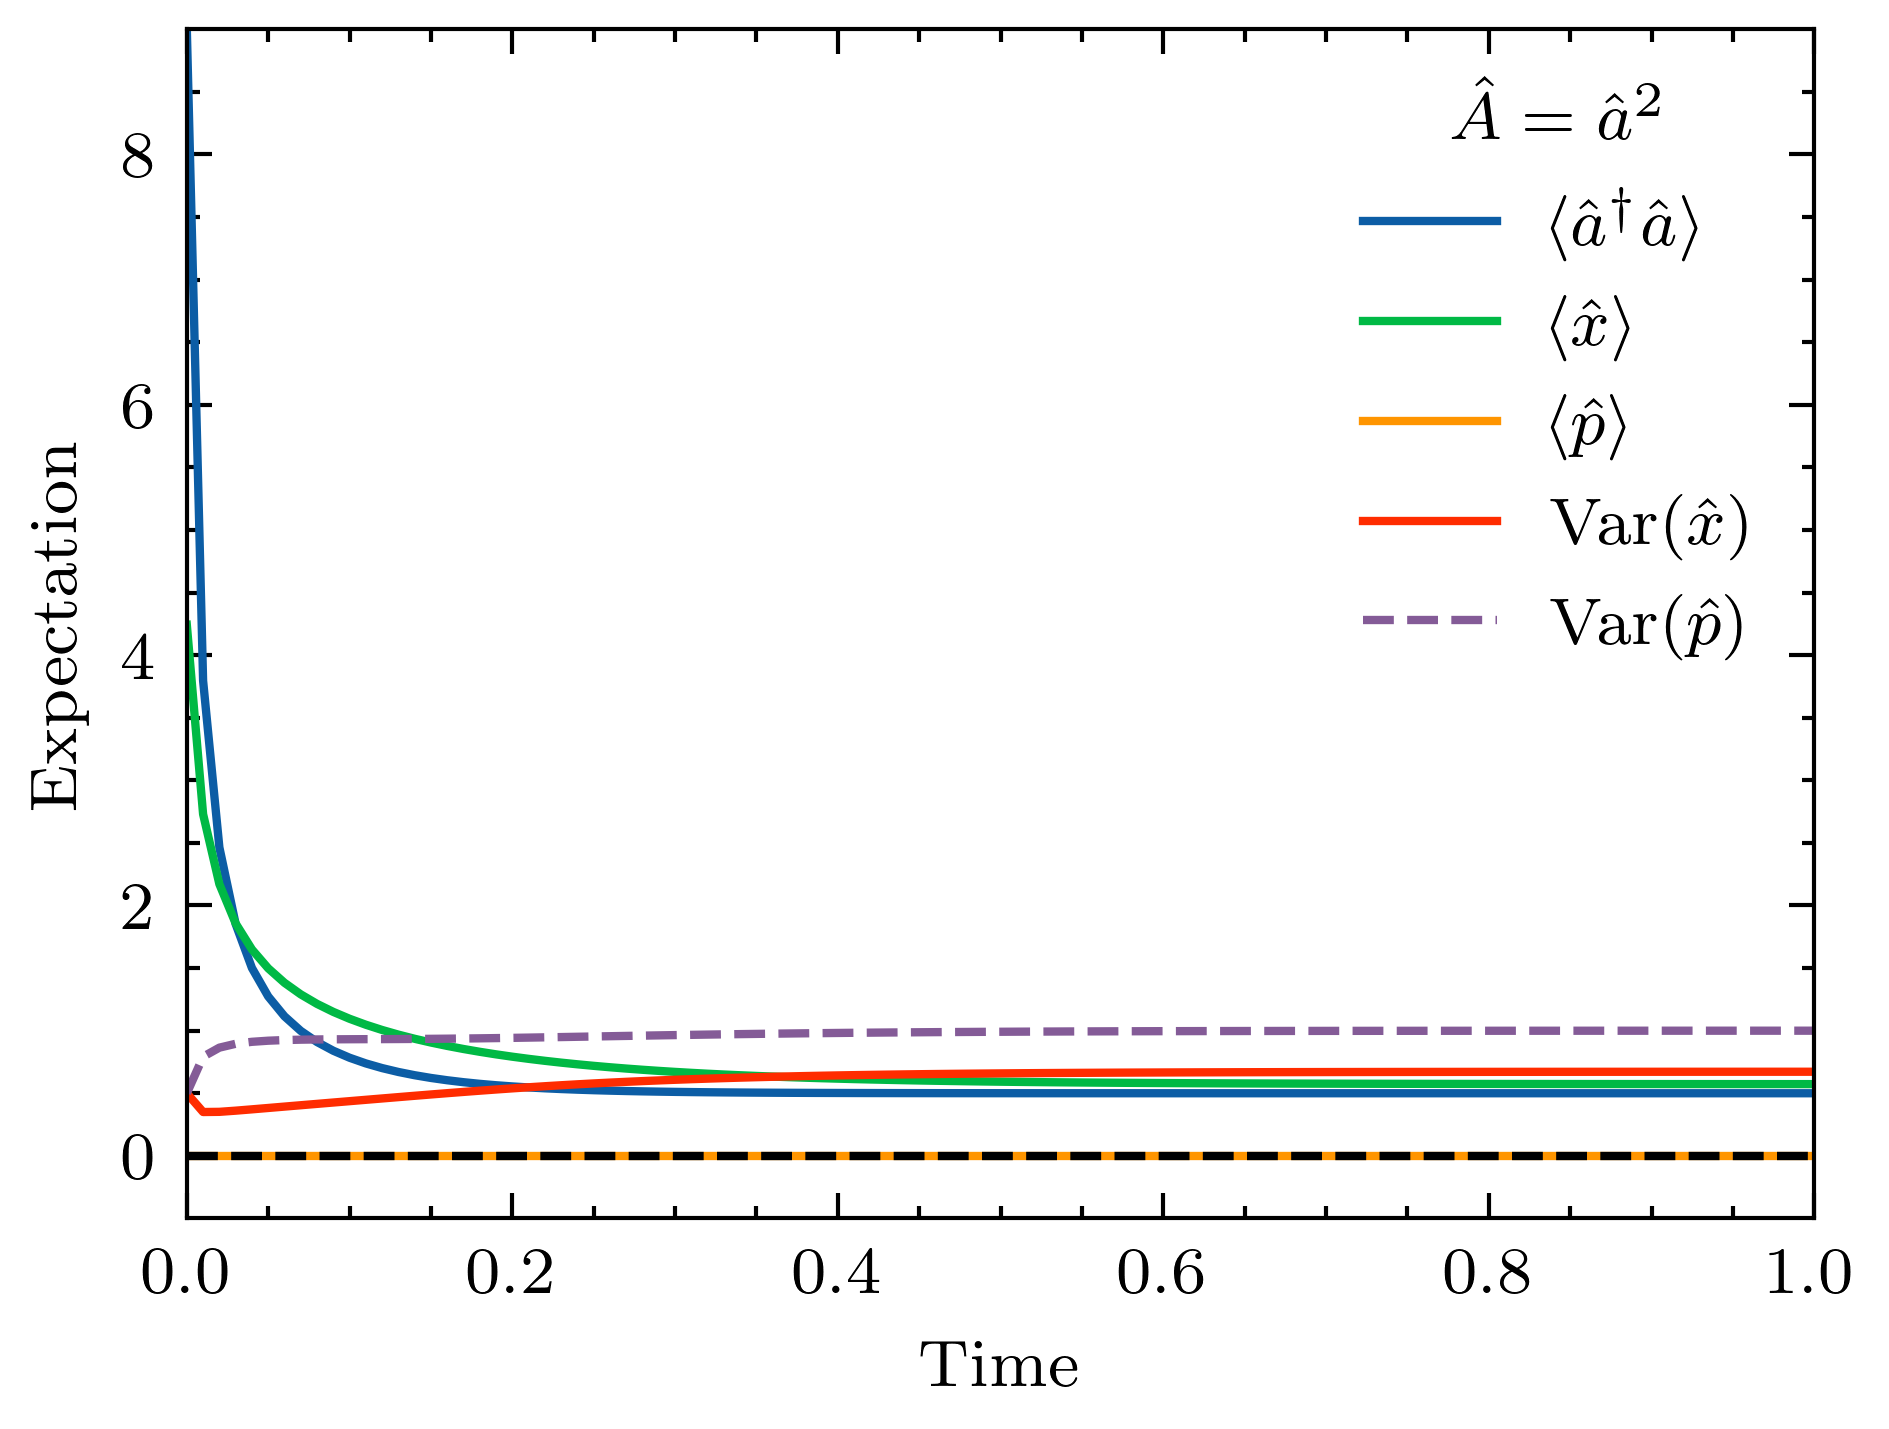

In [54]:
# graph of expectations

const_list_0 = np.full(len(tlist), 0)

ymax = max(qt.expect(n, result.states))
fig, ax = plt.subplots()

ax.plot(tlist, qt.expect(n, result.states), label="$\\langle\\hat{a}^\\dagger \\hat{a} \\rangle$")
# ax.plot(tlist, qt.expect(a, result.states), label="$\\langle\\hat{a}\\rangle$")
ax.plot(tlist, qt.expect(x, result.states), label="$\\langle\\hat{x}\\rangle$")
ax.plot(tlist, qt.expect(p, result.states), label="$\\langle\\hat{p}\\rangle$")
ax.plot(tlist, qt.variance(x, result.states), label="Var($\\hat{x}$)")
ax.plot(tlist, qt.variance(p, result.states), label="Var($\\hat{p}$)", linestyle="--")
ax.plot(tlist, const_list_0, color="black", linestyle="--")

ax.set(xlabel="Time")
ax.set(ylabel="Expectation")
# ax.legend(loc=0)
ax.legend(title = "$\\hat{A} = \\hat{a}^2$", loc=0)
ax.autoscale(tight=True)
ax.set_ylim([-0.5,ymax]);

fig.savefig("expects_aa.pdf")
fig.savefig("expects_aa.png", dpi=300)

In [6]:
def phase(alpha):
    return qt.ket2dm((alpha * qt.fock(N, 0)  + np.sqrt(1-alpha**2) * qt.fock(N, 1)).unit())

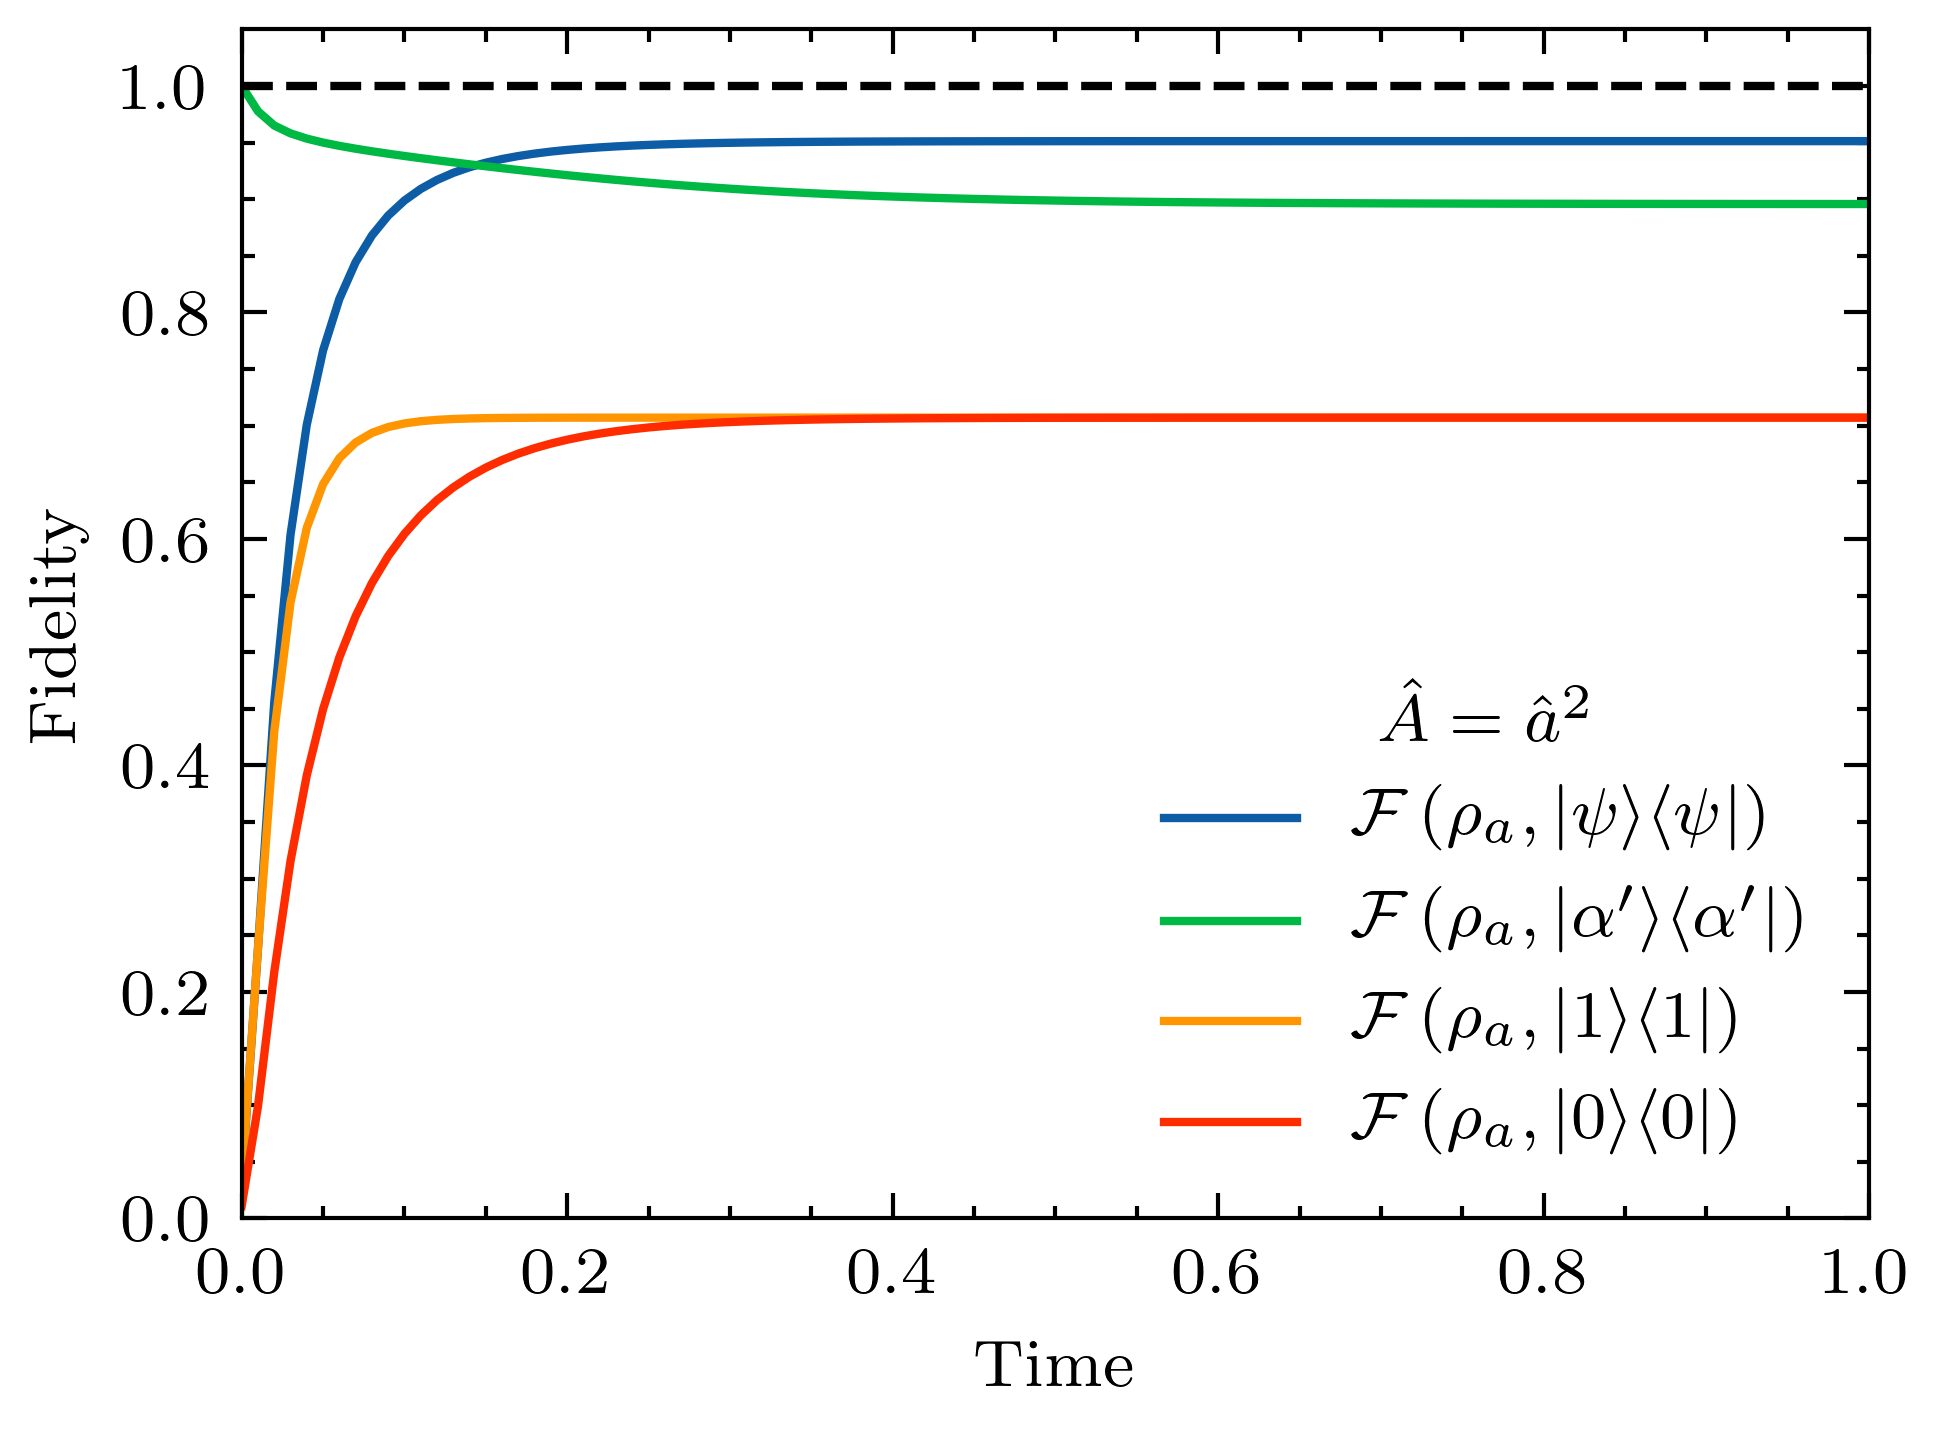

In [55]:
# graph of fidelities to target states

steady_state = qt.ket2dm((qt.fock(N, 0)  + qt.fock(N, 1))/np.sqrt(2))
const_list_1 = np.full(len(tlist), 1)

# fidelity to steady state
fid_list_steady = []
for idx, val in enumerate(result.states):
    fid_list_steady.append(qt.fidelity(val, steady_state))
    
    
# fidelity to equivalent coherent state
fid_list_coh = []
for idx, val in enumerate(result.states):
    fid_list_coh.append(qt.fidelity(val, qt.coherent(N, np.sqrt(qt.expect(n, val)))))
    

fid_list_one = []
for idx, val in enumerate(result.states):
    fid_list_one.append(qt.fidelity(val, qt.fock(N, 1)))


fid_list_zero = []
for idx, val in enumerate(result.states):
    fid_list_zero.append(qt.fidelity(val, qt.fock(N, 0)))


# fid_list_fock = []
# for idx, val in enumerate(result.states):
#     fid_list_fock.append(qt.fidelity(val, qt.fock(N, int(np.rint(qt.expect(n, val))))))

fig, ax = plt.subplots()
    
ax.plot(tlist, fid_list_steady, label="$\\mathcal{F}\\left(\\rho_a, |\\psi\\rangle\\langle \\psi |\\right)$")
ax.plot(tlist, fid_list_coh, label="$\\mathcal{F}\\left(\\rho_a, |\\alpha^\\prime\\rangle\\langle \\alpha^\\prime |\\right)$")
ax.plot(tlist, fid_list_one, label="$\\mathcal{F}\\left(\\rho_a, |1\\rangle\\langle 1|\\right)$")
ax.plot(tlist, fid_list_zero, label="$\\mathcal{F}\\left(\\rho_a, |0\\rangle\\langle 0|\\right)$")
# ax.plot(tlist, fid_list_fock, color="red")                         
ax.plot(tlist, const_list_1, linestyle="--", color="black")
ax.autoscale(tight=True)
ax.set(xlabel="Time")
ax.set(ylabel="Fidelity")
ax.set_ylim([0, 1.05]);
# ax.legend(loc=0)
ax.legend(title = "$\\hat{A} = \\hat{a}^2$", loc=0)

fig.savefig("fidelities_aa.pdf")
fig.savefig("fidelities_aa.png", dpi=300)


Checking mandelQ of steady-state

In [7]:
def mandelQ(state):
    _num = qt.variance(n, state)
    _denom = qt.expect(n, state)
    
    return (_num/_denom)-1

In [ ]:
# phase(alpha)
# result.states

In [9]:
mandelQ(phase(1/np.sqrt(2)))

-0.5000000000000001

In [10]:
mandelQ(result.states[-1])

-0.4999998407140287

# $\hat{A} = \hat{a}^3$

Let us generate some evolution

In [101]:
options=qt.Options(nsteps=4000)
# defining input parameters
N = 35 # hilbert space size
tlist = np.linspace(0, 1.0, 101) # times over which to solve
gamma = 8.0 # decay rate 
omega = 0.0 # free Hamiltonian frequency 
alphain = 3.0 # input coherent state amplitude

# defining operators
a = qt.destroy(N) # annihilation operator
n = qt.num(N) # number operator 
ad = a.dag() # creation operator 
x = (a + ad)/np.sqrt(2) # position operator. Equivalent to qt.position(N)
p = -1j * (a - ad)/np.sqrt(2) # momentum operator. Equivalent to qt.position(N)

# defining Hamiltonian
H = omega * ad * a


# input state
psi0 = qt.coherent(N, alphain, method="operator")
# psi0 = (qt.fock(N, 8) + qt.fock(N, 9) + qt.fock(N, 1) + qt.fock(N, 3) + qt.fock(N, 4) + qt.fock(N, 6)).unit()
coplist = [np.sqrt(gamma) * a**3]
result = qt.mesolve(H, psi0, tlist, coplist, [], options=options)

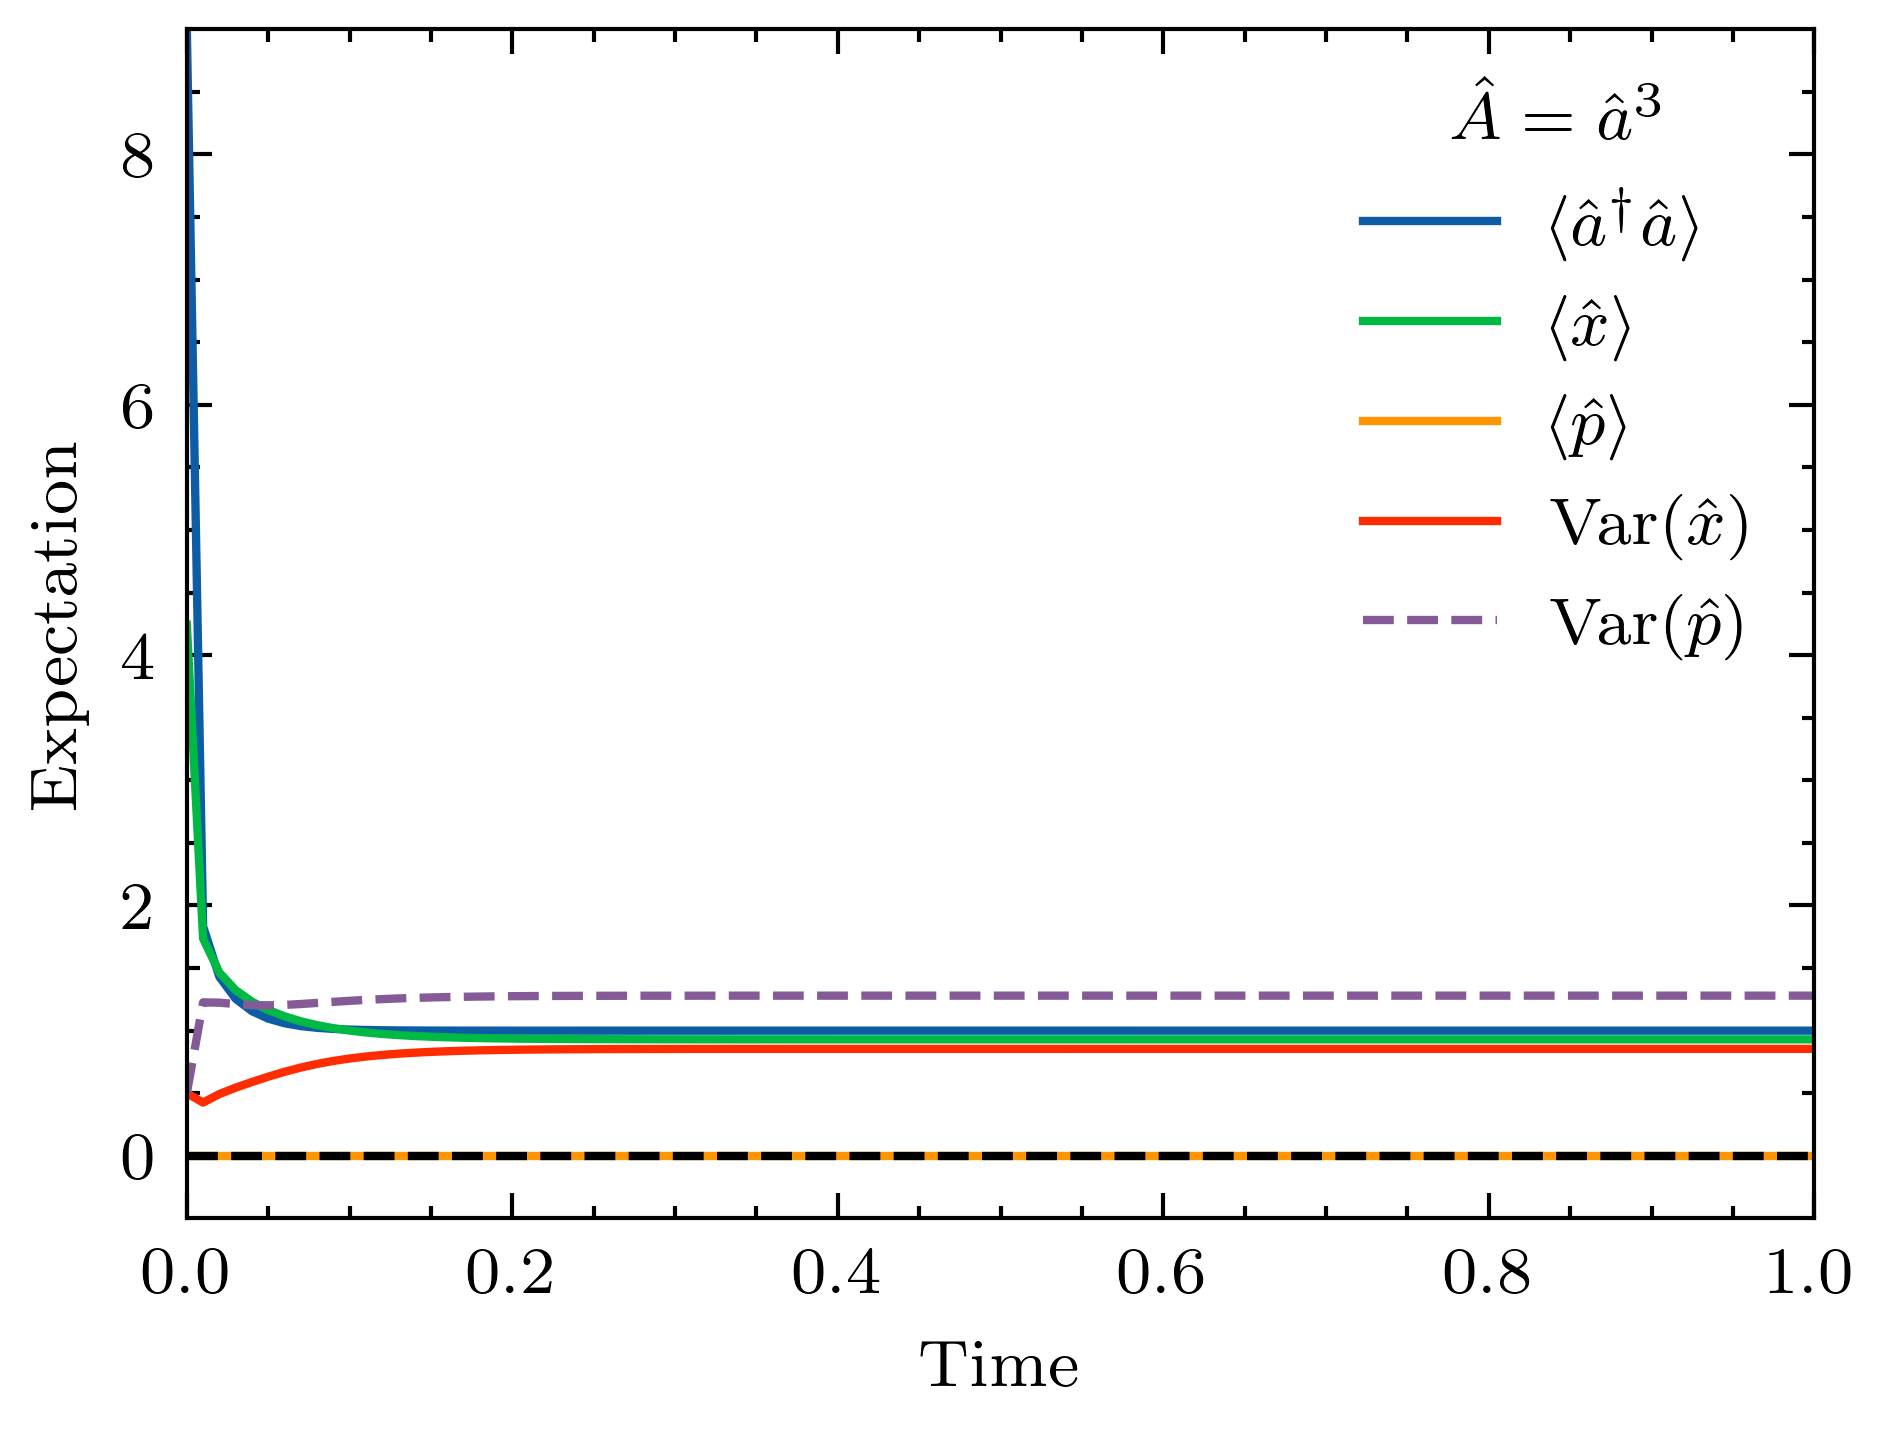

In [102]:
# graph of expectations

const_list_0 = np.full(len(tlist), 0)

ymax = max(qt.expect(n, result.states))
fig, ax = plt.subplots()

ax.plot(tlist, qt.expect(n, result.states), label="$\\langle\\hat{a}^\\dagger \\hat{a} \\rangle$")
# ax.plot(tlist, qt.expect(a, result.states), label="$\\langle\\hat{a}\\rangle$")
ax.plot(tlist, qt.expect(x, result.states), label="$\\langle\\hat{x}\\rangle$")
ax.plot(tlist, qt.expect(p, result.states), label="$\\langle\\hat{p}\\rangle$")
ax.plot(tlist, qt.variance(x, result.states), label="Var($\\hat{x}$)")
ax.plot(tlist, qt.variance(p, result.states), label="Var($\\hat{p}$)", linestyle="--")
ax.plot(tlist, const_list_0, color="black", linestyle="--")

ax.set(xlabel="Time")
ax.set(ylabel="Expectation")
# ax.legend(loc=0)
ax.legend(title = "$\\hat{A} = \\hat{a}^3$", loc=0)
ax.autoscale(tight=True)
ax.set_ylim([-0.5,ymax]);

fig.savefig("expects_aaa.pdf")
fig.savefig("expects_aaa.png", dpi=300)

In [46]:
def phase2(phi1, phi2):
    return qt.ket2dm(( qt.fock(N, 0)  + np.exp(1.0J* phi1) *  qt.fock(N, 1) + np.exp(1.0J * phi2) * qt.fock(N, 2)).unit())

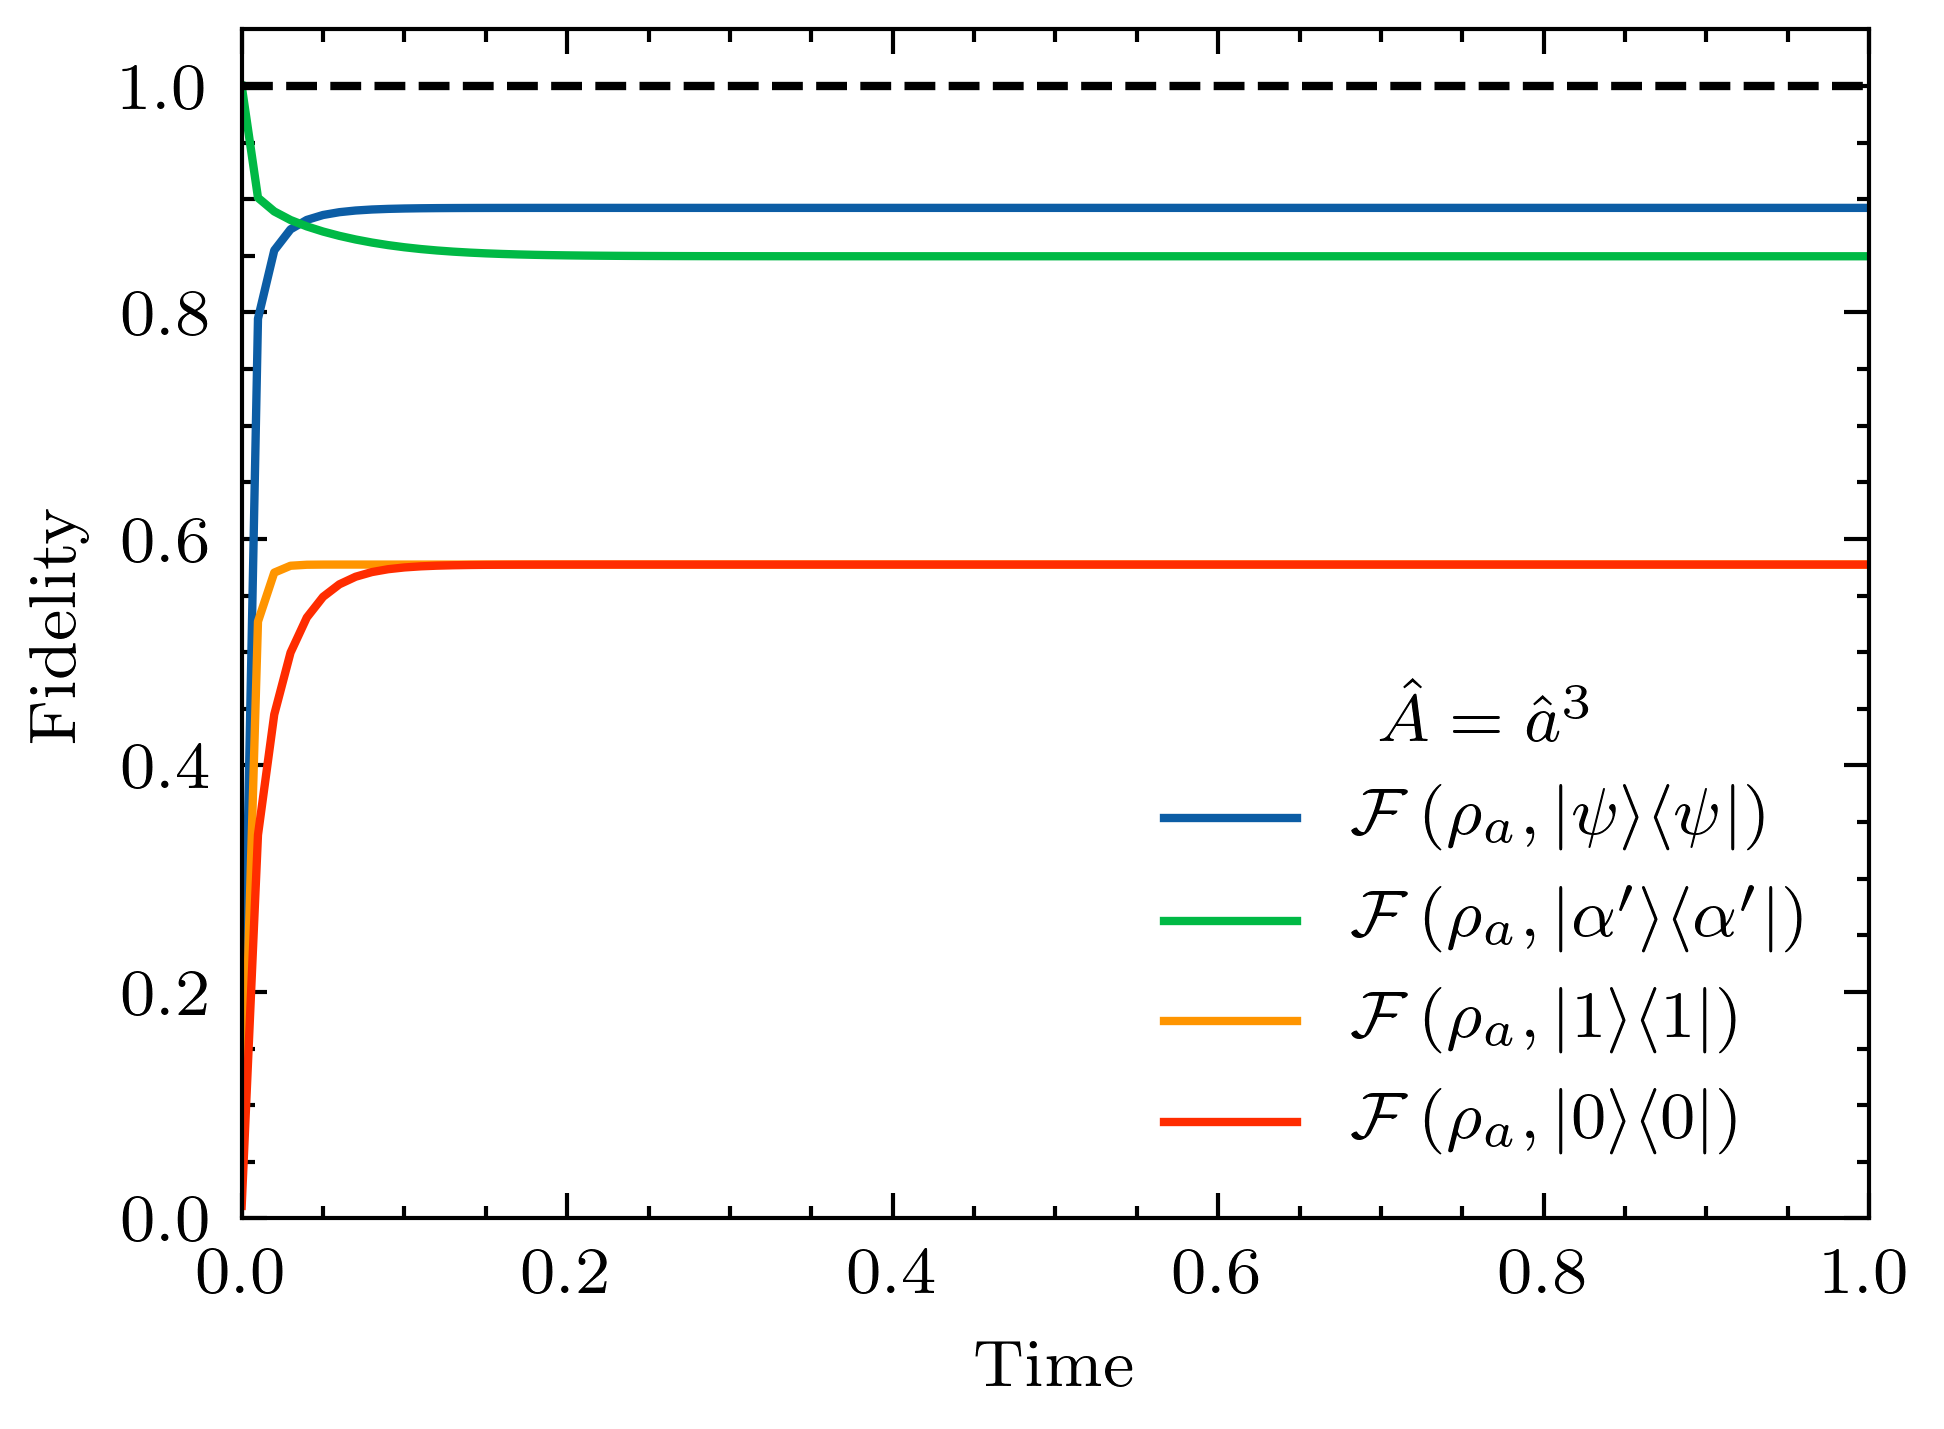

In [104]:
# graph of fidelities to target states

steady_state = phase2(0.0, 0.0)
const_list_1 = np.full(len(tlist), 1)

# fidelity to steady state
fid_list_steady = []
for idx, val in enumerate(result.states):
    fid_list_steady.append(qt.fidelity(val, steady_state))
    
    
# fidelity to equivalent coherent state
fid_list_coh = []
for idx, val in enumerate(result.states):
    fid_list_coh.append(qt.fidelity(val, qt.coherent(N, np.sqrt(qt.expect(n, val)))))
    

fid_list_one = []
for idx, val in enumerate(result.states):
    fid_list_one.append(qt.fidelity(val, qt.fock(N, 1)))


fid_list_zero = []
for idx, val in enumerate(result.states):
    fid_list_zero.append(qt.fidelity(val, qt.fock(N, 0)))


# fid_list_fock = []
# for idx, val in enumerate(result.states):
#     fid_list_fock.append(qt.fidelity(val, qt.fock(N, int(np.rint(qt.expect(n, val))))))

fig, ax = plt.subplots()
    
ax.plot(tlist, fid_list_steady, label="$\\mathcal{F}\\left(\\rho_a, |\\psi\\rangle\\langle \\psi |\\right)$")
ax.plot(tlist, fid_list_coh, label="$\\mathcal{F}\\left(\\rho_a, |\\alpha^\\prime\\rangle\\langle \\alpha^\\prime |\\right)$")
ax.plot(tlist, fid_list_one, label="$\\mathcal{F}\\left(\\rho_a, |1\\rangle\\langle 1|\\right)$")
ax.plot(tlist, fid_list_zero, label="$\\mathcal{F}\\left(\\rho_a, |0\\rangle\\langle 0|\\right)$")
# ax.plot(tlist, fid_list_fock, color="red")                         
ax.plot(tlist, const_list_1, linestyle="--", color="black")
ax.autoscale(tight=True)
ax.set(xlabel="Time")
ax.set(ylabel="Fidelity")
ax.set_ylim([0, 1.05]);
# ax.legend(loc=0)
ax.legend(title = "$\\hat{A} = \\hat{a}^3$", loc=0)

fig.savefig("fidelities_aaa.pdf")
fig.savefig("fidelities_aaa.png", dpi=300)


# $\hat{A} = \hat{a}\left(\hat{n} - 1\right)$

## Expectations and fidelities

In [24]:
options=qt.Options(nsteps=10000)
# options=qt.Options()
# defining input parameters
N = 100 # hilbert space size
tlist = np.linspace(0, 1.0, 101) # times over which to solve
gamma = 8.0 # decay rate 
omega = 0.0 # free Hamiltonian frequency 
alphain = 3.0 # input coherent state amplitude

# defining operators
a = qt.destroy(N) # annihilation operator
n = qt.num(N) # number operator 
ad = a.dag() # creation operator 
x = (a + ad)/np.sqrt(2) # position operator. Equivalent to qt.position(N)
p = -1j * (a - ad)/np.sqrt(2) # momentum operator. Equivalent to qt.position(N)

# defining Hamiltonian
H = omega * ad * a


# input state
psi0 = qt.coherent(N, alphain, method="operator")
# psi0 = (qt.fock(N, 8) + qt.fock(N, 9) + qt.fock(N, 1) + qt.fock(N, 3) + qt.fock(N, 4) + qt.fock(N, 6)).unit()
coplist = [np.sqrt(gamma) * a*(n - 1)]

In [16]:
import time

In [25]:
start_time = time.time()
result = qt.mesolve(H, psi0, tlist, coplist, [], options=options)
end_time = time.time()
print(end_time - start_time)

1054.153662443161


In [26]:
1054/60

17.566666666666666

In [19]:
%timeit result = qt.mesolve(H, psi0, tlist, coplist, [], options=options)

341 ms ± 77.2 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


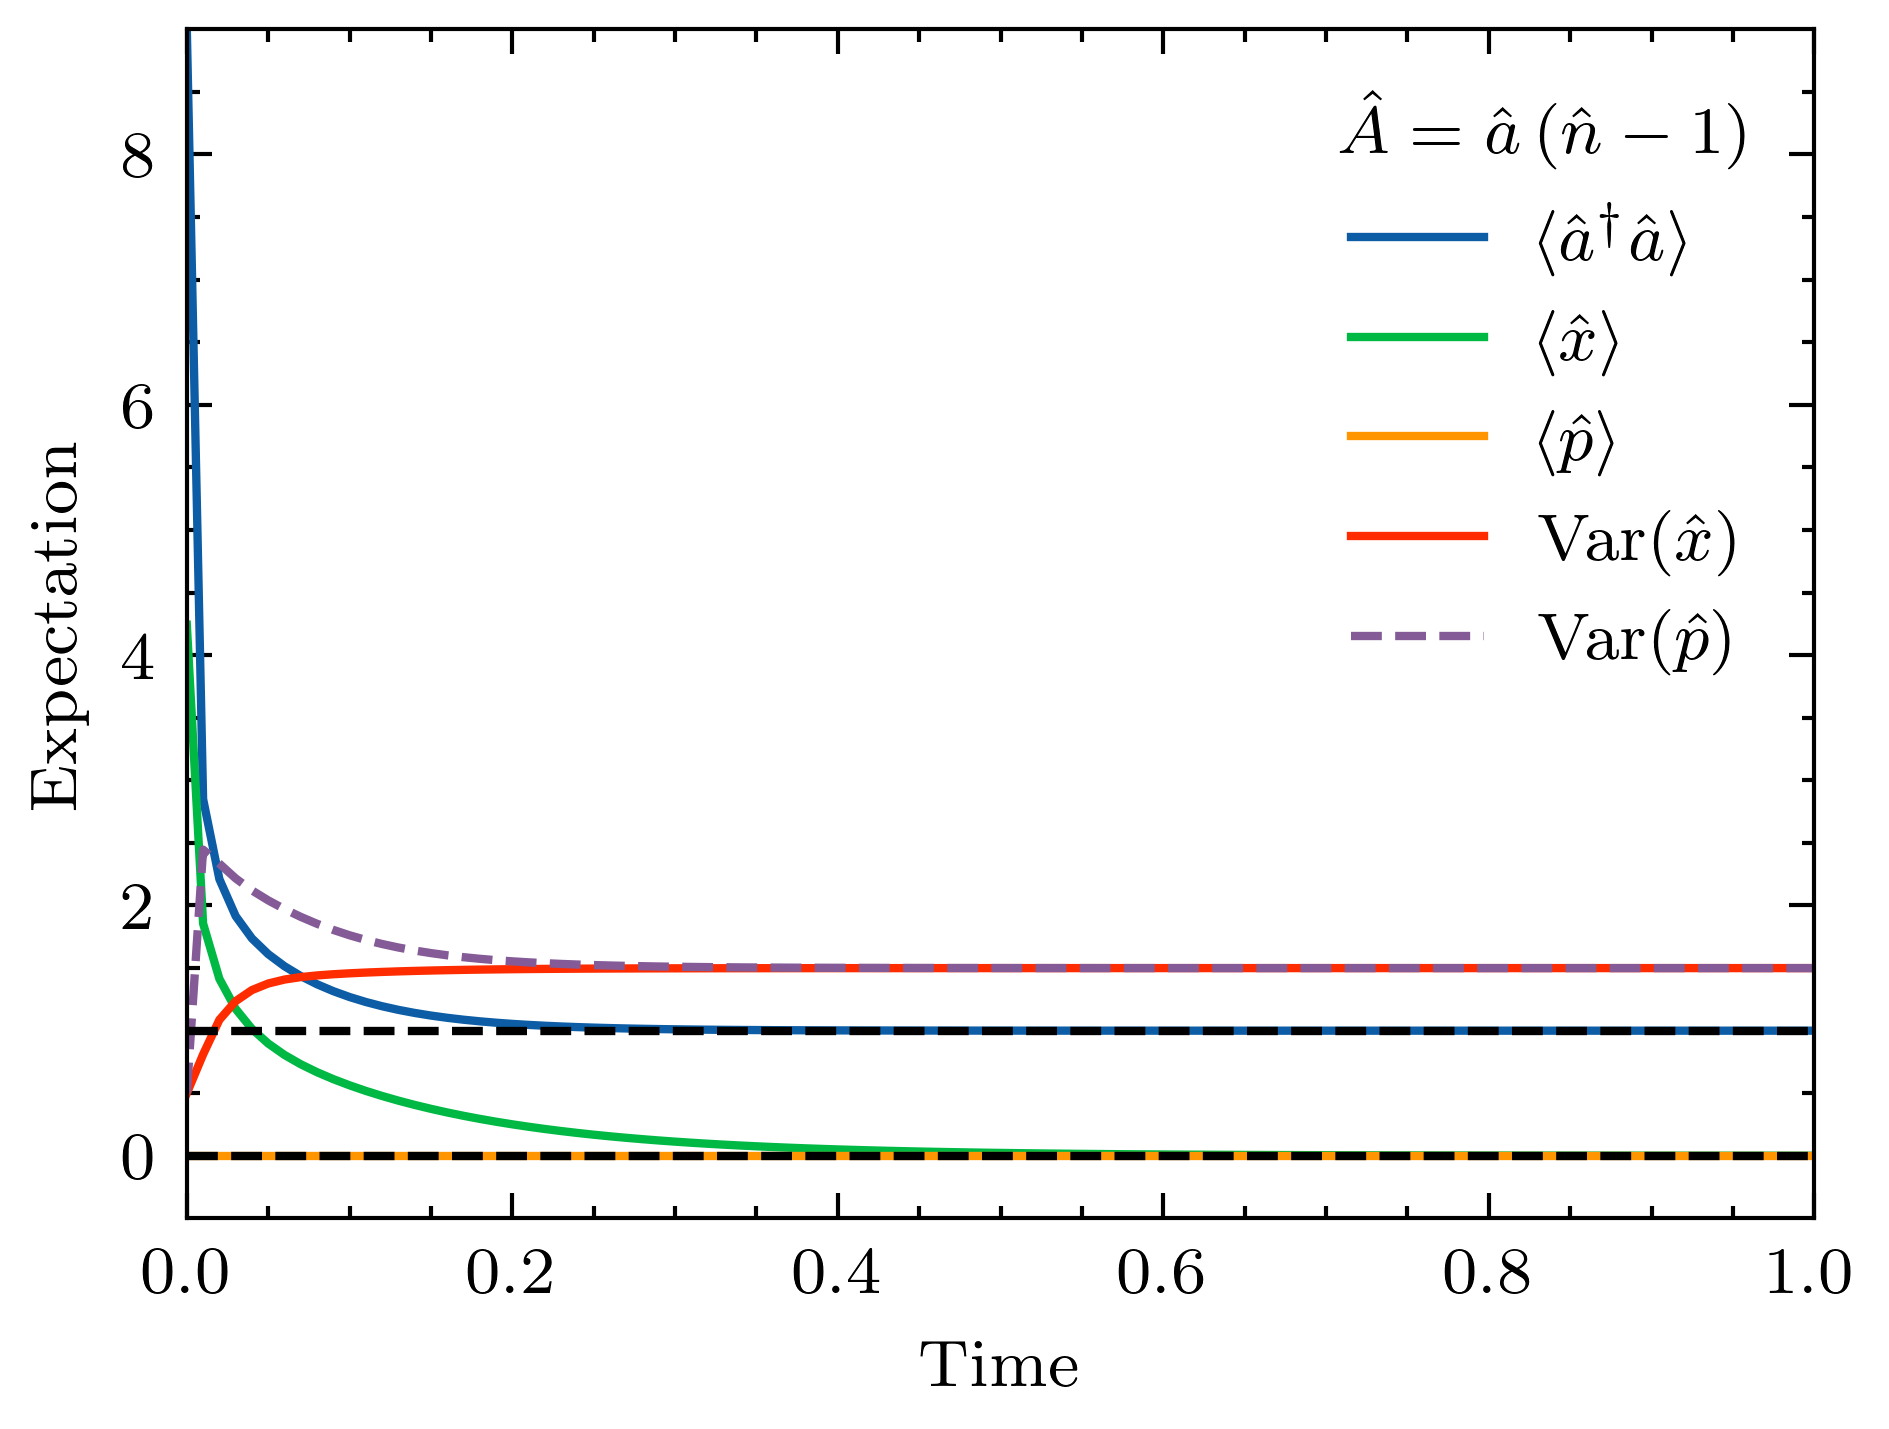

In [121]:
# graph of expectations

const_list_0 = np.full(len(tlist), 0)
const_list_1 = np.full(len(tlist), 1)

ymax = max(qt.expect(n, result.states))
fig, ax = plt.subplots()

ax.plot(tlist, qt.expect(n, result.states), label="$\\langle\\hat{a}^\\dagger \\hat{a} \\rangle$")
# ax.plot(tlist, qt.expect(a, result.states), label="$\\langle\\hat{a}\\rangle$")
ax.plot(tlist, qt.expect(x, result.states), label="$\\langle\\hat{x}\\rangle$")
ax.plot(tlist, qt.expect(p, result.states), label="$\\langle\\hat{p}\\rangle$")
ax.plot(tlist, qt.variance(x, result.states), label="Var($\\hat{x}$)")
ax.plot(tlist, qt.variance(p, result.states), label="Var($\\hat{p}$)", linestyle="--")
ax.plot(tlist, const_list_0, color="black", linestyle="--")
ax.plot(tlist, const_list_1, color="black", linestyle="--")

ax.set(xlabel="Time")
ax.set(ylabel="Expectation")
# ax.legend(loc=0)
ax.legend(title = "$\\hat{A} = \\hat{a}\\left(\\hat{n} - 1\\right)$", loc=0)
ax.autoscale(tight=True)
ax.set_ylim([-0.5,ymax]);

# fig.savefig("expects_ncl1.pdf")
# fig.savefig("expects_ncl1.png", dpi=300)

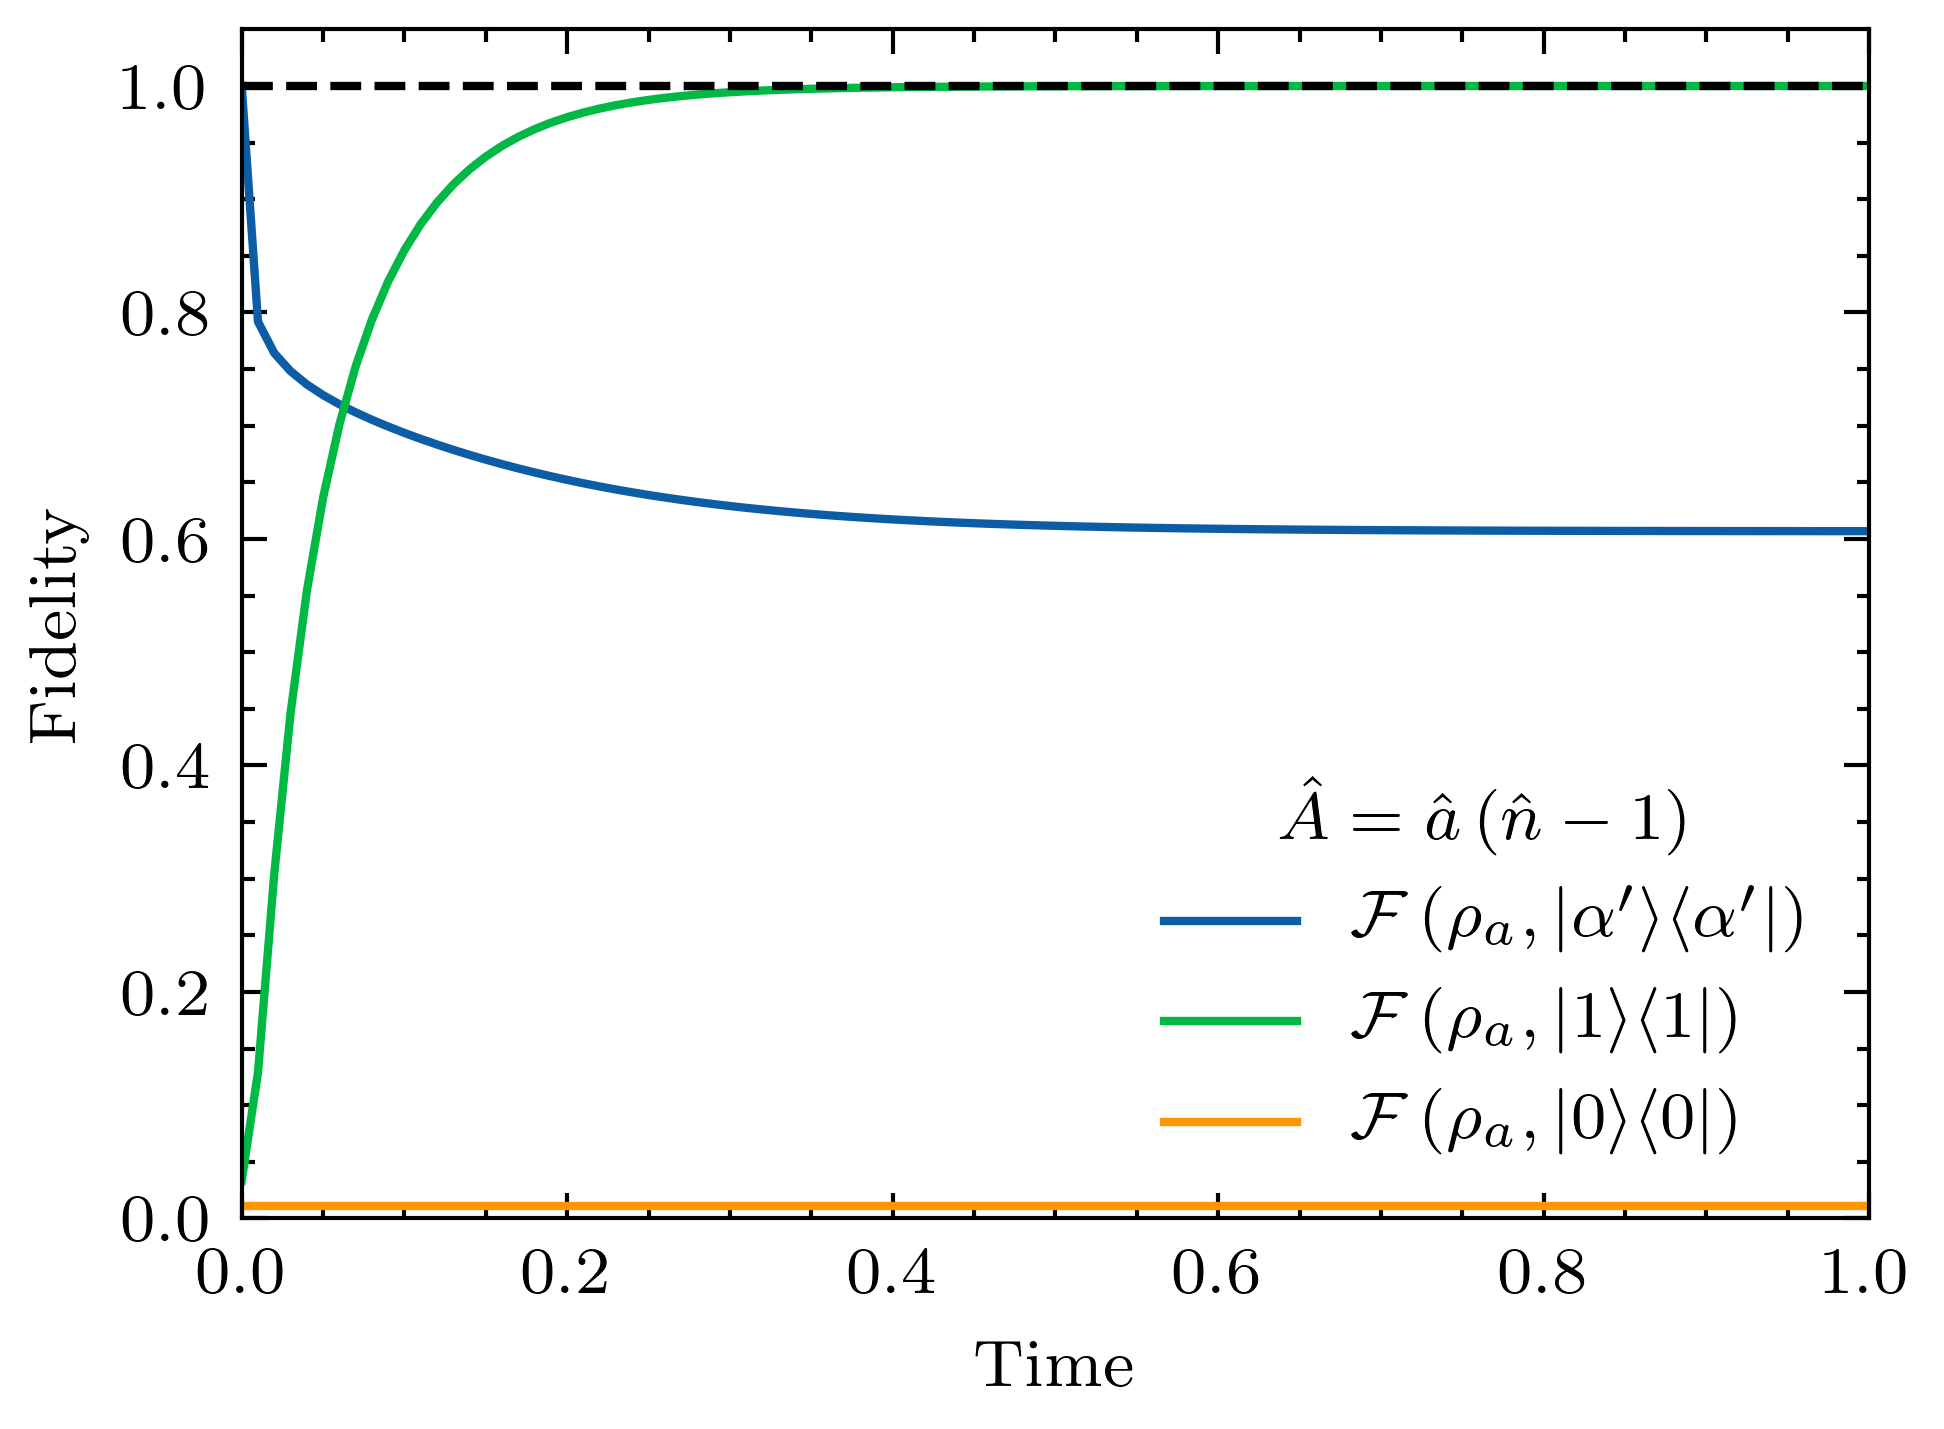

In [125]:
# graph of fidelities to target states

const_list_1 = np.full(len(tlist), 1)


    
    
# fidelity to equivalent coherent state
fid_list_coh = []
for idx, val in enumerate(result.states):
    fid_list_coh.append(qt.fidelity(val, qt.coherent(N, np.sqrt(qt.expect(n, val)))))
    

fid_list_one = []
for idx, val in enumerate(result.states):
    fid_list_one.append(qt.fidelity(val, qt.fock(N, 1)))


fid_list_zero = []
for idx, val in enumerate(result.states):
    fid_list_zero.append(qt.fidelity(val, qt.fock(N, 0)))


# fid_list_fock = []
# for idx, val in enumerate(result.states):
#     fid_list_fock.append(qt.fidelity(val, qt.fock(N, int(np.rint(qt.expect(n, val))))))

fig, ax = plt.subplots()
    
ax.plot(tlist, fid_list_coh, label="$\\mathcal{F}\\left(\\rho_a, |\\alpha^\\prime\\rangle\\langle \\alpha^\\prime |\\right)$")
ax.plot(tlist, fid_list_one, label="$\\mathcal{F}\\left(\\rho_a, |1\\rangle\\langle 1|\\right)$")
ax.plot(tlist, fid_list_zero, label="$\\mathcal{F}\\left(\\rho_a, |0\\rangle\\langle 0|\\right)$")
# ax.plot(tlist, fid_list_fock, color="red")                         
ax.plot(tlist, const_list_1, linestyle="--", color="black")
ax.autoscale(tight=True)
ax.set(xlabel="Time")
ax.set(ylabel="Fidelity")
ax.set_ylim([0, 1.05]);
# ax.legend(loc=0)
ax.legend(title = "$\\hat{A} = \\hat{a}\\left(\\hat{n}-1\\right)$", loc=0)

# fig.savefig("fidelities_ncl1.pdf")
# fig.savefig("fidelities_ncl1.png", dpi=300)


## Max fidelity to single-photon state vs $\alpha$

In [7]:
options = qt.Options(nsteps=10000)
N = 35
tlist = np.linspace(0, 0.5, 51)
gamma = 8.0
omega = 0.0

a = qt.destroy(N)
n = qt.num(N)
ad = a.dag()

H = omega * ad * a

def ncl_fidelity_to_single_photon(alphain):
    psi0 = qt.coherent(N, alphain, method="operator")
    coplist = [np.sqrt(gamma) * a * (n-1)]
    result = qt.mesolve(H, psi0, tlist, coplist, [], options=options)
    return qt.fidelity(result.states[-1], qt.fock(N, 1))

In [8]:
alist = np.arange(0.0, 3.1, 0.1)
# ncl_fidelity_to_single_photon(3.0)
alist

array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2,
       1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5,
       2.6, 2.7, 2.8, 2.9, 3. ])

In [9]:
fidlist = []
for idx, val in enumerate(alist):
    fidlist.append(ncl_fidelity_to_single_photon(val))
    update_progress(idx / len(alist))
update_progress(1)

Progress: [####################] 100.0%


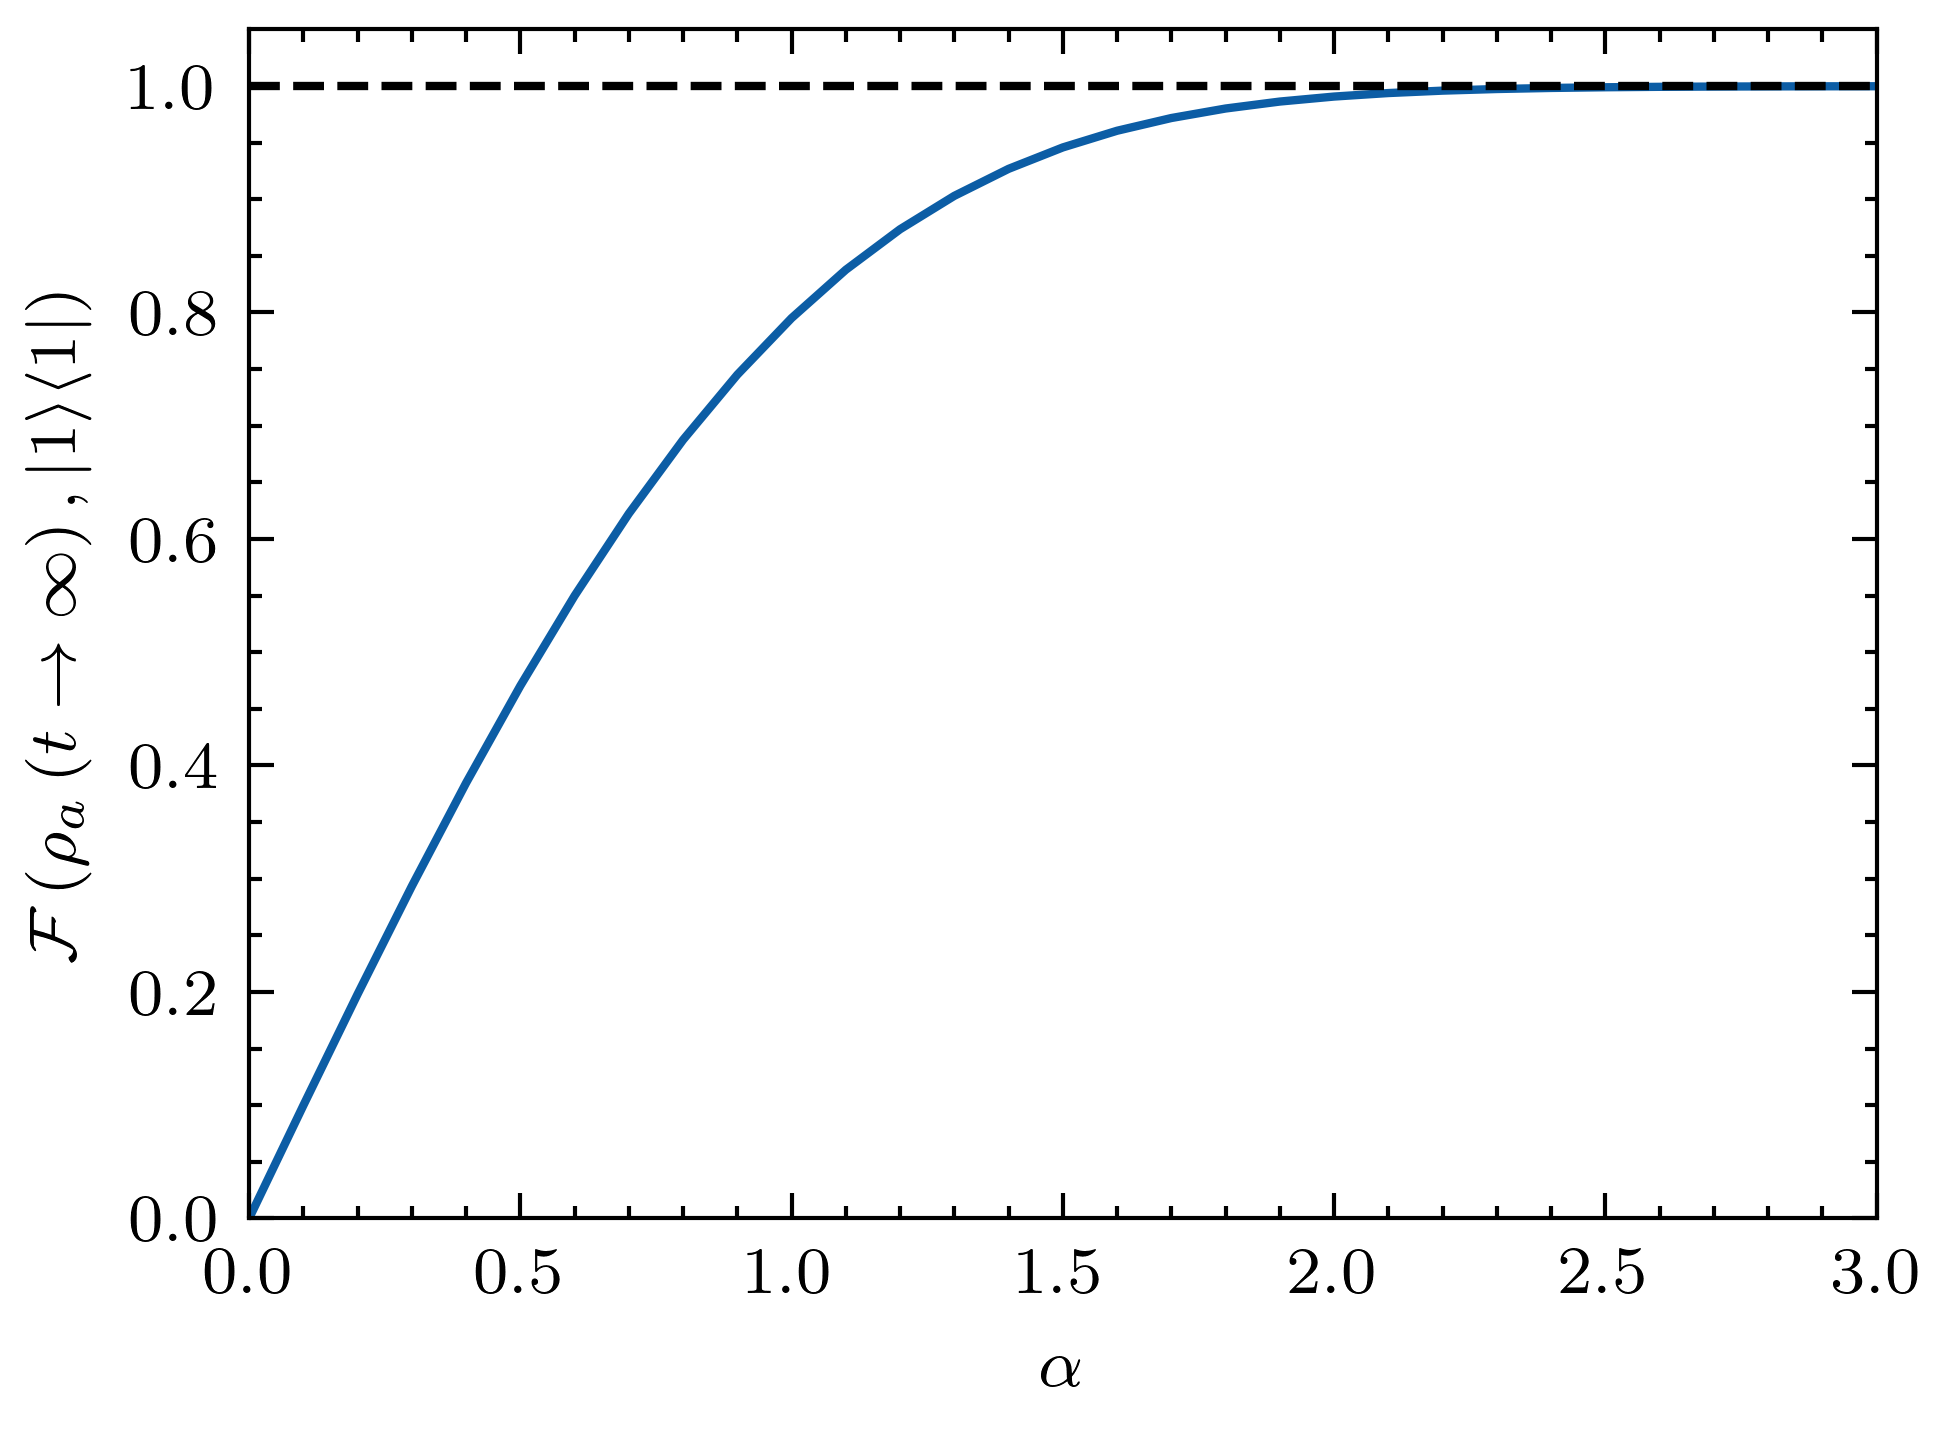

In [12]:
const_list_1 = np.full(len(alist), 1)

fig, ax = plt.subplots()

ax.plot(alist, fidlist, label="$\\gamma = 8.0$")
ax.plot(alist, const_list_1, color="black", linestyle="--")
ax.autoscale(tight=True)
ax.set(xlabel="$\\alpha$")
ax.set(ylabel="$\\mathcal{F}\\left(\\rho_a\\left( t \\rightarrow \\infty \\right), |1\\rangle\\langle 1|\\right)$")
# ax.legend(title = "$\\hat{A} = \\hat{a}\\left(\\hat{n}-1\\right)$", loc=0)
ax.set_ylim([0, 1.05]);
ax.set_xlim([0, 3.0]);

fig.savefig("fidelities_ncl1_vs_alpha.pdf")
fig.savefig("fidelities_ncl1_vs_alpha.png", dpi=300)

# $\hat{A} = \hat{a}\left(\hat{n} - 2\right)$

## Expectations and fidelities against time

In [126]:
options=qt.Options(nsteps=10000)
# options=qt.Options()
# defining input parameters
N = 35 # hilbert space size
tlist = np.linspace(0, 1.0, 101) # times over which to solve
gamma = 8.0 # decay rate 
omega = 0.0 # free Hamiltonian frequency 
alphain = 3.0 # input coherent state amplitude

# defining operators
a = qt.destroy(N) # annihilation operator
n = qt.num(N) # number operator 
ad = a.dag() # creation operator 
x = (a + ad)/np.sqrt(2) # position operator. Equivalent to qt.position(N)
p = -1j * (a - ad)/np.sqrt(2) # momentum operator. Equivalent to qt.position(N)

# defining Hamiltonian
H = omega * ad * a


# input state
psi0 = qt.coherent(N, alphain, method="operator")
# psi0 = (qt.fock(N, 8) + qt.fock(N, 9) + qt.fock(N, 1) + qt.fock(N, 3) + qt.fock(N, 4) + qt.fock(N, 6)).unit()
coplist = [np.sqrt(gamma) * a*(n - 2)]
result = qt.mesolve(H, psi0, tlist, coplist, [], options=options)

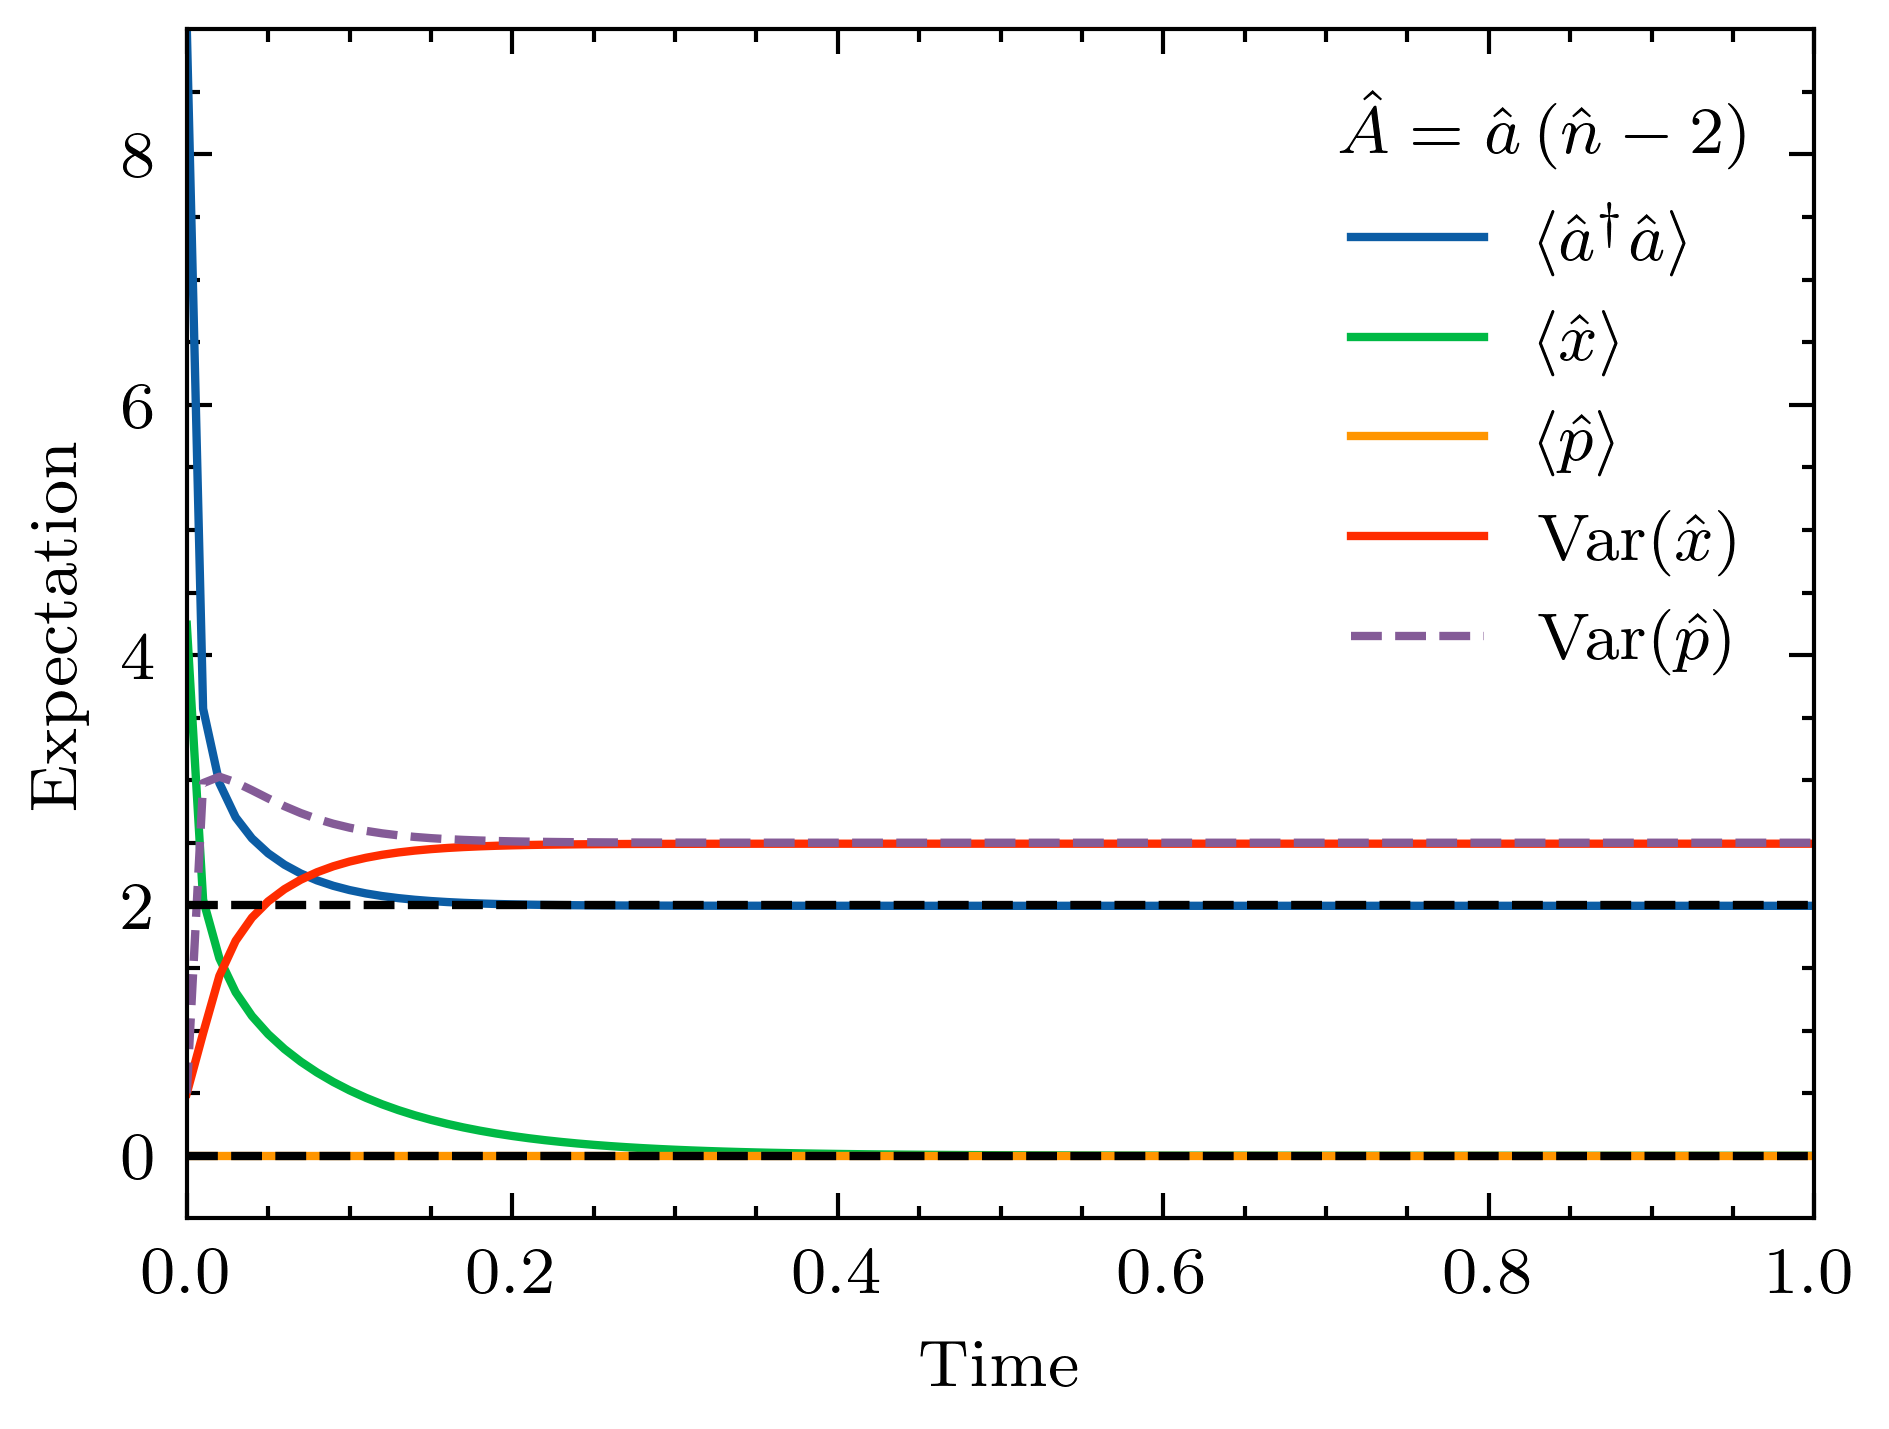

In [132]:
# graph of expectations

const_list_0 = np.full(len(tlist), 0)
const_list_2 = np.full(len(tlist), 2)

ymax = max(qt.expect(n, result.states))
fig, ax = plt.subplots()

ax.plot(tlist, qt.expect(n, result.states), label="$\\langle\\hat{a}^\\dagger \\hat{a} \\rangle$")
# ax.plot(tlist, qt.expect(a, result.states), label="$\\langle\\hat{a}\\rangle$")
ax.plot(tlist, qt.expect(x, result.states), label="$\\langle\\hat{x}\\rangle$")
ax.plot(tlist, qt.expect(p, result.states), label="$\\langle\\hat{p}\\rangle$")
ax.plot(tlist, qt.variance(x, result.states), label="Var($\\hat{x}$)")
ax.plot(tlist, qt.variance(p, result.states), label="Var($\\hat{p}$)", linestyle="--")
ax.plot(tlist, const_list_0, color="black", linestyle="--")
ax.plot(tlist, const_list_2, color="black", linestyle="--")

ax.set(xlabel="Time")
ax.set(ylabel="Expectation")
# ax.legend(loc=0)
ax.legend(title = "$\\hat{A} = \\hat{a}\\left(\\hat{n} - 2\\right)$", loc=0)
ax.autoscale(tight=True)
ax.set_ylim([-0.5,ymax]);

fig.savefig("expects_ncl2.pdf")
fig.savefig("expects_ncl2.png", dpi=300)

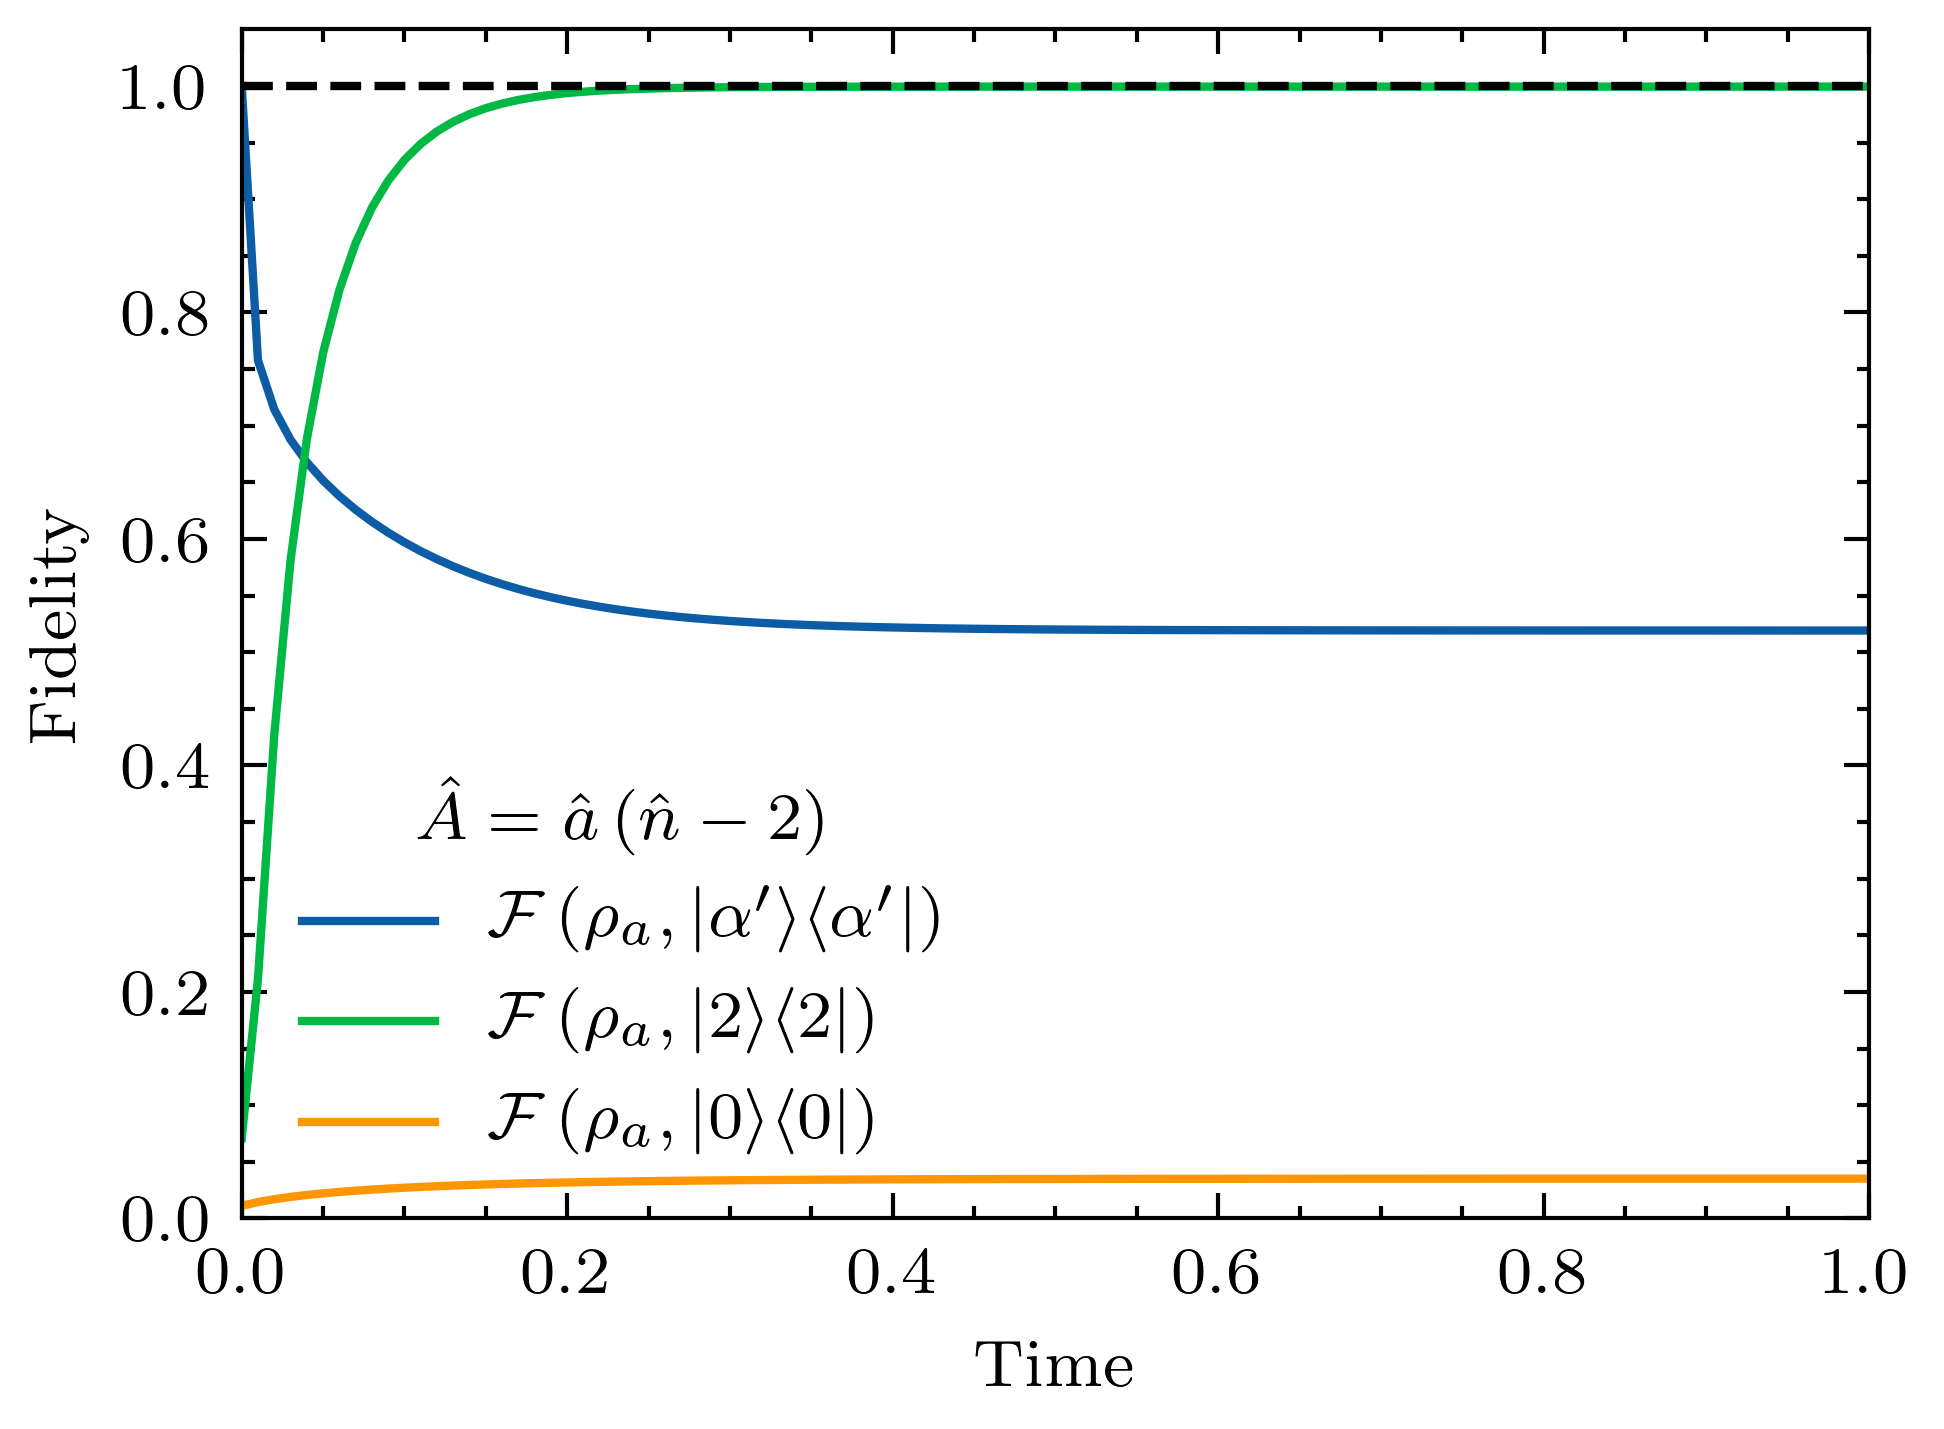

In [131]:
# graph of fidelities to target states

const_list_1 = np.full(len(tlist), 1)


    
    
# fidelity to equivalent coherent state
fid_list_coh = []
for idx, val in enumerate(result.states):
    fid_list_coh.append(qt.fidelity(val, qt.coherent(N, np.sqrt(qt.expect(n, val)))))
    

fid_list_two = []
for idx, val in enumerate(result.states):
    fid_list_two.append(qt.fidelity(val, qt.fock(N, 2)))
    
fid_list_one = []
for idx, val in enumerate(result.states):
    fid_list_one.append(qt.fidelity(val, qt.fock(N, 1)))


fid_list_zero = []
for idx, val in enumerate(result.states):
    fid_list_zero.append(qt.fidelity(val, qt.fock(N, 0)))


# fid_list_fock = []
# for idx, val in enumerate(result.states):
#     fid_list_fock.append(qt.fidelity(val, qt.fock(N, int(np.rint(qt.expect(n, val))))))

fig, ax = plt.subplots()
    
ax.plot(tlist, fid_list_coh, label="$\\mathcal{F}\\left(\\rho_a, |\\alpha^\\prime\\rangle\\langle \\alpha^\\prime |\\right)$")
ax.plot(tlist, fid_list_two, label="$\\mathcal{F}\\left(\\rho_a, |2\\rangle\\langle 2|\\right)$")
# ax.plot(tlist, fid_list_one, label="$\\mathcal{F}\\left(\\rho_a, |1\\rangle\\langle 1|\\right)$")
ax.plot(tlist, fid_list_zero, label="$\\mathcal{F}\\left(\\rho_a, |0\\rangle\\langle 0|\\right)$")
# ax.plot(tlist, fid_list_fock, color="red")                         
ax.plot(tlist, const_list_1, linestyle="--", color="black")
ax.autoscale(tight=True)
ax.set(xlabel="Time")
ax.set(ylabel="Fidelity")
ax.set_ylim([0, 1.05]);
# ax.legend(loc=0)
ax.legend(title = "$\\hat{A} = \\hat{a}\\left(\\hat{n}-2\\right)$", loc=0)

fig.savefig("fidelities_ncl2.pdf")
fig.savefig("fidelities_ncl2.png", dpi=300)
